In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 1,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : [],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_1_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_e_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(7012081, 923)
(7012081, 1)
validation
(855802, 923)
(855802, 1)
test
(1048121, 923)
(1048121, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 923)]             0         


 dense (Dense)               (None, 1024)              946176    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1635329 (6.24 MB)


Trainable params: 1635329 (6.24 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/702 [..............................] - ETA: 17:24 - loss: 0.0723 - STD: 1.4090e-04 - MAE: 0.2275

  4/702 [..............................] - ETA: 16s - loss: 0.0722 - STD: 6.2029e-04 - MAE: 0.2276  

  7/702 [..............................] - ETA: 16s - loss: 0.0698 - STD: 0.0014 - MAE: 0.2246    

 10/702 [..............................] - ETA: 16s - loss: 0.0674 - STD: 0.0021 - MAE: 0.2216

 13/702 [..............................] - ETA: 16s - loss: 0.0663 - STD: 0.0029 - MAE: 0.2203

 16/702 [..............................] - ETA: 16s - loss: 0.0650 - STD: 0.0041 - MAE: 0.2184

 19/702 [..............................] - ETA: 16s - loss: 0.0637 - STD: 0.0059 - MAE: 0.2164

 22/702 [..............................] - ETA: 16s - loss: 0.0621 - STD: 0.0085 - MAE: 0.2137

 25/702 [>.............................] - ETA: 16s - loss: 0.0599 - STD: 0.0132 - MAE: 0.2098

 28/702 [>.............................] - ETA: 16s - loss: 0.0571 - STD: 0.0211 - MAE: 0.2040

 31/702 [>.............................] - ETA: 16s - loss: 0.0536 - STD: 0.0326 - MAE: 0.1958

 34/702 [>.............................] - ETA: 16s - loss: 0.0502 - STD: 0.0475 - MAE: 0.1872

 37/702 [>.............................] - ETA: 16s - loss: 0.0473 - STD: 0.0633 - MAE: 0.1798

 40/702 [>.............................] - ETA: 15s - loss: 0.0450 - STD: 0.0781 - MAE: 0.1737

 43/702 [>.............................] - ETA: 15s - loss: 0.0430 - STD: 0.0913 - MAE: 0.1685

 46/702 [>.............................] - ETA: 15s - loss: 0.0411 - STD: 0.1016 - MAE: 0.1635

 49/702 [=>............................] - ETA: 15s - loss: 0.0393 - STD: 0.1094 - MAE: 0.1590

 52/702 [=>............................] - ETA: 15s - loss: 0.0378 - STD: 0.1148 - MAE: 0.1549

 55/702 [=>............................] - ETA: 15s - loss: 0.0364 - STD: 0.1191 - MAE: 0.1514

 58/702 [=>............................] - ETA: 15s - loss: 0.0351 - STD: 0.1234 - MAE: 0.1481

 61/702 [=>............................] - ETA: 15s - loss: 0.0339 - STD: 0.1280 - MAE: 0.1448

 64/702 [=>............................] - ETA: 15s - loss: 0.0328 - STD: 0.1328 - MAE: 0.1419

 67/702 [=>............................] - ETA: 15s - loss: 0.0318 - STD: 0.1372 - MAE: 0.1391

 70/702 [=>............................] - ETA: 15s - loss: 0.0309 - STD: 0.1411 - MAE: 0.1365

 73/702 [==>...........................] - ETA: 15s - loss: 0.0301 - STD: 0.1444 - MAE: 0.1341

 76/702 [==>...........................] - ETA: 15s - loss: 0.0293 - STD: 0.1472 - MAE: 0.1318

 79/702 [==>...........................] - ETA: 14s - loss: 0.0285 - STD: 0.1498 - MAE: 0.1297

 81/702 [==>...........................] - ETA: 15s - loss: 0.0280 - STD: 0.1517 - MAE: 0.1283

 83/702 [==>...........................] - ETA: 15s - loss: 0.0276 - STD: 0.1535 - MAE: 0.1270

 85/702 [==>...........................] - ETA: 14s - loss: 0.0272 - STD: 0.1553 - MAE: 0.1258

 88/702 [==>...........................] - ETA: 14s - loss: 0.0265 - STD: 0.1578 - MAE: 0.1240

 90/702 [==>...........................] - ETA: 14s - loss: 0.0262 - STD: 0.1593 - MAE: 0.1228

 93/702 [==>...........................] - ETA: 14s - loss: 0.0256 - STD: 0.1613 - MAE: 0.1212

 96/702 [===>..........................] - ETA: 14s - loss: 0.0251 - STD: 0.1633 - MAE: 0.1197

 99/702 [===>..........................] - ETA: 14s - loss: 0.0246 - STD: 0.1652 - MAE: 0.1182

102/702 [===>..........................] - ETA: 14s - loss: 0.0241 - STD: 0.1671 - MAE: 0.1168

105/702 [===>..........................] - ETA: 14s - loss: 0.0237 - STD: 0.1688 - MAE: 0.1154

108/702 [===>..........................] - ETA: 14s - loss: 0.0232 - STD: 0.1705 - MAE: 0.1141

111/702 [===>..........................] - ETA: 14s - loss: 0.0228 - STD: 0.1720 - MAE: 0.1129

114/702 [===>..........................] - ETA: 14s - loss: 0.0225 - STD: 0.1735 - MAE: 0.1117

117/702 [====>.........................] - ETA: 14s - loss: 0.0221 - STD: 0.1749 - MAE: 0.1106

120/702 [====>.........................] - ETA: 14s - loss: 0.0217 - STD: 0.1763 - MAE: 0.1094

123/702 [====>.........................] - ETA: 14s - loss: 0.0214 - STD: 0.1775 - MAE: 0.1084

125/702 [====>.........................] - ETA: 14s - loss: 0.0212 - STD: 0.1784 - MAE: 0.1077

128/702 [====>.........................] - ETA: 14s - loss: 0.0209 - STD: 0.1796 - MAE: 0.1067

131/702 [====>.........................] - ETA: 13s - loss: 0.0206 - STD: 0.1808 - MAE: 0.1058

134/702 [====>.........................] - ETA: 13s - loss: 0.0203 - STD: 0.1819 - MAE: 0.1049

137/702 [====>.........................] - ETA: 13s - loss: 0.0200 - STD: 0.1830 - MAE: 0.1040

140/702 [====>.........................] - ETA: 13s - loss: 0.0198 - STD: 0.1840 - MAE: 0.1032

143/702 [=====>........................] - ETA: 13s - loss: 0.0195 - STD: 0.1850 - MAE: 0.1024

146/702 [=====>........................] - ETA: 13s - loss: 0.0193 - STD: 0.1859 - MAE: 0.1016

149/702 [=====>........................] - ETA: 13s - loss: 0.0190 - STD: 0.1868 - MAE: 0.1009

152/702 [=====>........................] - ETA: 13s - loss: 0.0188 - STD: 0.1877 - MAE: 0.1001

155/702 [=====>........................] - ETA: 13s - loss: 0.0186 - STD: 0.1886 - MAE: 0.0994

158/702 [=====>........................] - ETA: 13s - loss: 0.0184 - STD: 0.1894 - MAE: 0.0987

161/702 [=====>........................] - ETA: 13s - loss: 0.0181 - STD: 0.1902 - MAE: 0.0980

164/702 [======>.......................] - ETA: 13s - loss: 0.0179 - STD: 0.1909 - MAE: 0.0974

166/702 [======>.......................] - ETA: 13s - loss: 0.0178 - STD: 0.1914 - MAE: 0.0970

169/702 [======>.......................] - ETA: 13s - loss: 0.0176 - STD: 0.1922 - MAE: 0.0963

172/702 [======>.......................] - ETA: 12s - loss: 0.0174 - STD: 0.1929 - MAE: 0.0957

175/702 [======>.......................] - ETA: 12s - loss: 0.0173 - STD: 0.1936 - MAE: 0.0952

178/702 [======>.......................] - ETA: 12s - loss: 0.0171 - STD: 0.1943 - MAE: 0.0946

181/702 [======>.......................] - ETA: 12s - loss: 0.0169 - STD: 0.1949 - MAE: 0.0941

184/702 [======>.......................] - ETA: 12s - loss: 0.0168 - STD: 0.1955 - MAE: 0.0936

187/702 [======>.......................] - ETA: 12s - loss: 0.0166 - STD: 0.1961 - MAE: 0.0930

189/702 [=======>......................] - ETA: 12s - loss: 0.0165 - STD: 0.1965 - MAE: 0.0927

191/702 [=======>......................] - ETA: 12s - loss: 0.0164 - STD: 0.1969 - MAE: 0.0924

194/702 [=======>......................] - ETA: 12s - loss: 0.0163 - STD: 0.1974 - MAE: 0.0919

197/702 [=======>......................] - ETA: 12s - loss: 0.0161 - STD: 0.1980 - MAE: 0.0915

200/702 [=======>......................] - ETA: 12s - loss: 0.0160 - STD: 0.1985 - MAE: 0.0910

203/702 [=======>......................] - ETA: 12s - loss: 0.0159 - STD: 0.1990 - MAE: 0.0906

206/702 [=======>......................] - ETA: 12s - loss: 0.0157 - STD: 0.1995 - MAE: 0.0901

209/702 [=======>......................] - ETA: 12s - loss: 0.0156 - STD: 0.2000 - MAE: 0.0897

212/702 [========>.....................] - ETA: 11s - loss: 0.0155 - STD: 0.2005 - MAE: 0.0893

215/702 [========>.....................] - ETA: 11s - loss: 0.0153 - STD: 0.2010 - MAE: 0.0889

218/702 [========>.....................] - ETA: 11s - loss: 0.0152 - STD: 0.2014 - MAE: 0.0885

221/702 [========>.....................] - ETA: 11s - loss: 0.0151 - STD: 0.2019 - MAE: 0.0881

224/702 [========>.....................] - ETA: 11s - loss: 0.0150 - STD: 0.2023 - MAE: 0.0877

227/702 [========>.....................] - ETA: 11s - loss: 0.0149 - STD: 0.2027 - MAE: 0.0873

230/702 [========>.....................] - ETA: 11s - loss: 0.0148 - STD: 0.2031 - MAE: 0.0869

233/702 [========>.....................] - ETA: 11s - loss: 0.0146 - STD: 0.2035 - MAE: 0.0866

236/702 [=========>....................] - ETA: 11s - loss: 0.0145 - STD: 0.2040 - MAE: 0.0862

239/702 [=========>....................] - ETA: 11s - loss: 0.0144 - STD: 0.2043 - MAE: 0.0859

242/702 [=========>....................] - ETA: 11s - loss: 0.0144 - STD: 0.2047 - MAE: 0.0856

245/702 [=========>....................] - ETA: 11s - loss: 0.0143 - STD: 0.2050 - MAE: 0.0853

248/702 [=========>....................] - ETA: 11s - loss: 0.0142 - STD: 0.2054 - MAE: 0.0850

251/702 [=========>....................] - ETA: 11s - loss: 0.0141 - STD: 0.2057 - MAE: 0.0847

254/702 [=========>....................] - ETA: 10s - loss: 0.0140 - STD: 0.2061 - MAE: 0.0844

257/702 [=========>....................] - ETA: 10s - loss: 0.0139 - STD: 0.2064 - MAE: 0.0841

260/702 [==========>...................] - ETA: 10s - loss: 0.0138 - STD: 0.2067 - MAE: 0.0838

263/702 [==========>...................] - ETA: 10s - loss: 0.0137 - STD: 0.2071 - MAE: 0.0835

266/702 [==========>...................] - ETA: 10s - loss: 0.0136 - STD: 0.2074 - MAE: 0.0832

269/702 [==========>...................] - ETA: 10s - loss: 0.0135 - STD: 0.2077 - MAE: 0.0829

272/702 [==========>...................] - ETA: 10s - loss: 0.0135 - STD: 0.2080 - MAE: 0.0826

275/702 [==========>...................] - ETA: 10s - loss: 0.0134 - STD: 0.2083 - MAE: 0.0823

278/702 [==========>...................] - ETA: 10s - loss: 0.0133 - STD: 0.2086 - MAE: 0.0821

281/702 [===========>..................] - ETA: 10s - loss: 0.0132 - STD: 0.2089 - MAE: 0.0818

284/702 [===========>..................] - ETA: 10s - loss: 0.0131 - STD: 0.2092 - MAE: 0.0815

287/702 [===========>..................] - ETA: 10s - loss: 0.0131 - STD: 0.2095 - MAE: 0.0812

290/702 [===========>..................] - ETA: 10s - loss: 0.0130 - STD: 0.2098 - MAE: 0.0810

293/702 [===========>..................] - ETA: 9s - loss: 0.0130 - STD: 0.2100 - MAE: 0.0811 

296/702 [===========>..................] - ETA: 9s - loss: 0.0129 - STD: 0.2102 - MAE: 0.0810

299/702 [===========>..................] - ETA: 9s - loss: 0.0129 - STD: 0.2104 - MAE: 0.0808

302/702 [===========>..................] - ETA: 9s - loss: 0.0128 - STD: 0.2107 - MAE: 0.0806

305/702 [============>.................] - ETA: 9s - loss: 0.0128 - STD: 0.2109 - MAE: 0.0804

308/702 [============>.................] - ETA: 9s - loss: 0.0127 - STD: 0.2111 - MAE: 0.0802

311/702 [============>.................] - ETA: 9s - loss: 0.0126 - STD: 0.2113 - MAE: 0.0800

314/702 [============>.................] - ETA: 9s - loss: 0.0126 - STD: 0.2116 - MAE: 0.0798

316/702 [============>.................] - ETA: 9s - loss: 0.0125 - STD: 0.2117 - MAE: 0.0797

319/702 [============>.................] - ETA: 9s - loss: 0.0125 - STD: 0.2120 - MAE: 0.0795

321/702 [============>.................] - ETA: 9s - loss: 0.0124 - STD: 0.2121 - MAE: 0.0793

324/702 [============>.................] - ETA: 9s - loss: 0.0124 - STD: 0.2123 - MAE: 0.0791

327/702 [============>.................] - ETA: 9s - loss: 0.0123 - STD: 0.2125 - MAE: 0.0789

330/702 [=============>................] - ETA: 9s - loss: 0.0123 - STD: 0.2127 - MAE: 0.0787

333/702 [=============>................] - ETA: 8s - loss: 0.0122 - STD: 0.2129 - MAE: 0.0785

335/702 [=============>................] - ETA: 8s - loss: 0.0122 - STD: 0.2131 - MAE: 0.0784

338/702 [=============>................] - ETA: 8s - loss: 0.0121 - STD: 0.2133 - MAE: 0.0782

340/702 [=============>................] - ETA: 8s - loss: 0.0121 - STD: 0.2134 - MAE: 0.0780

342/702 [=============>................] - ETA: 8s - loss: 0.0120 - STD: 0.2135 - MAE: 0.0779

344/702 [=============>................] - ETA: 8s - loss: 0.0120 - STD: 0.2137 - MAE: 0.0778

346/702 [=============>................] - ETA: 8s - loss: 0.0119 - STD: 0.2138 - MAE: 0.0777

348/702 [=============>................] - ETA: 8s - loss: 0.0119 - STD: 0.2140 - MAE: 0.0775

350/702 [=============>................] - ETA: 8s - loss: 0.0119 - STD: 0.2141 - MAE: 0.0774

352/702 [==============>...............] - ETA: 8s - loss: 0.0118 - STD: 0.2142 - MAE: 0.0773

354/702 [==============>...............] - ETA: 8s - loss: 0.0118 - STD: 0.2143 - MAE: 0.0771

357/702 [==============>...............] - ETA: 8s - loss: 0.0117 - STD: 0.2145 - MAE: 0.0770

359/702 [==============>...............] - ETA: 8s - loss: 0.0117 - STD: 0.2146 - MAE: 0.0768

361/702 [==============>...............] - ETA: 8s - loss: 0.0117 - STD: 0.2148 - MAE: 0.0767

363/702 [==============>...............] - ETA: 8s - loss: 0.0116 - STD: 0.2149 - MAE: 0.0766

365/702 [==============>...............] - ETA: 8s - loss: 0.0116 - STD: 0.2150 - MAE: 0.0765

367/702 [==============>...............] - ETA: 8s - loss: 0.0116 - STD: 0.2151 - MAE: 0.0764

369/702 [==============>...............] - ETA: 8s - loss: 0.0115 - STD: 0.2152 - MAE: 0.0762

371/702 [==============>...............] - ETA: 8s - loss: 0.0115 - STD: 0.2153 - MAE: 0.0761

374/702 [==============>...............] - ETA: 8s - loss: 0.0115 - STD: 0.2155 - MAE: 0.0759

376/702 [===============>..............] - ETA: 8s - loss: 0.0114 - STD: 0.2156 - MAE: 0.0758

378/702 [===============>..............] - ETA: 7s - loss: 0.0114 - STD: 0.2157 - MAE: 0.0757

381/702 [===============>..............] - ETA: 7s - loss: 0.0114 - STD: 0.2159 - MAE: 0.0756

383/702 [===============>..............] - ETA: 7s - loss: 0.0113 - STD: 0.2160 - MAE: 0.0755

385/702 [===============>..............] - ETA: 7s - loss: 0.0113 - STD: 0.2161 - MAE: 0.0753

388/702 [===============>..............] - ETA: 7s - loss: 0.0112 - STD: 0.2163 - MAE: 0.0752

391/702 [===============>..............] - ETA: 7s - loss: 0.0112 - STD: 0.2164 - MAE: 0.0750

394/702 [===============>..............] - ETA: 7s - loss: 0.0112 - STD: 0.2166 - MAE: 0.0749

397/702 [===============>..............] - ETA: 7s - loss: 0.0111 - STD: 0.2167 - MAE: 0.0747

400/702 [================>.............] - ETA: 7s - loss: 0.0111 - STD: 0.2169 - MAE: 0.0746

403/702 [================>.............] - ETA: 7s - loss: 0.0110 - STD: 0.2171 - MAE: 0.0744

406/702 [================>.............] - ETA: 7s - loss: 0.0110 - STD: 0.2172 - MAE: 0.0743

408/702 [================>.............] - ETA: 7s - loss: 0.0110 - STD: 0.2173 - MAE: 0.0742

410/702 [================>.............] - ETA: 7s - loss: 0.0109 - STD: 0.2174 - MAE: 0.0741

412/702 [================>.............] - ETA: 7s - loss: 0.0109 - STD: 0.2175 - MAE: 0.0740

414/702 [================>.............] - ETA: 7s - loss: 0.0109 - STD: 0.2176 - MAE: 0.0739

416/702 [================>.............] - ETA: 7s - loss: 0.0108 - STD: 0.2177 - MAE: 0.0738

418/702 [================>.............] - ETA: 7s - loss: 0.0108 - STD: 0.2178 - MAE: 0.0737

421/702 [================>.............] - ETA: 6s - loss: 0.0108 - STD: 0.2179 - MAE: 0.0736

423/702 [=================>............] - ETA: 6s - loss: 0.0108 - STD: 0.2180 - MAE: 0.0735

425/702 [=================>............] - ETA: 6s - loss: 0.0107 - STD: 0.2181 - MAE: 0.0734

428/702 [=================>............] - ETA: 6s - loss: 0.0107 - STD: 0.2183 - MAE: 0.0733

431/702 [=================>............] - ETA: 6s - loss: 0.0107 - STD: 0.2184 - MAE: 0.0732

434/702 [=================>............] - ETA: 6s - loss: 0.0106 - STD: 0.2185 - MAE: 0.0731

437/702 [=================>............] - ETA: 6s - loss: 0.0106 - STD: 0.2186 - MAE: 0.0730

439/702 [=================>............] - ETA: 6s - loss: 0.0106 - STD: 0.2187 - MAE: 0.0729

441/702 [=================>............] - ETA: 6s - loss: 0.0106 - STD: 0.2188 - MAE: 0.0728

443/702 [=================>............] - ETA: 6s - loss: 0.0105 - STD: 0.2189 - MAE: 0.0727

445/702 [==================>...........] - ETA: 6s - loss: 0.0105 - STD: 0.2190 - MAE: 0.0726

448/702 [==================>...........] - ETA: 6s - loss: 0.0105 - STD: 0.2191 - MAE: 0.0725

451/702 [==================>...........] - ETA: 6s - loss: 0.0104 - STD: 0.2192 - MAE: 0.0724

454/702 [==================>...........] - ETA: 6s - loss: 0.0104 - STD: 0.2193 - MAE: 0.0723

456/702 [==================>...........] - ETA: 6s - loss: 0.0104 - STD: 0.2194 - MAE: 0.0722

458/702 [==================>...........] - ETA: 6s - loss: 0.0104 - STD: 0.2195 - MAE: 0.0721

460/702 [==================>...........] - ETA: 5s - loss: 0.0103 - STD: 0.2196 - MAE: 0.0720

463/702 [==================>...........] - ETA: 5s - loss: 0.0103 - STD: 0.2197 - MAE: 0.0719

465/702 [==================>...........] - ETA: 5s - loss: 0.0103 - STD: 0.2198 - MAE: 0.0718

467/702 [==================>...........] - ETA: 5s - loss: 0.0103 - STD: 0.2199 - MAE: 0.0717

469/702 [===================>..........] - ETA: 5s - loss: 0.0102 - STD: 0.2200 - MAE: 0.0717

471/702 [===================>..........] - ETA: 5s - loss: 0.0102 - STD: 0.2200 - MAE: 0.0716

473/702 [===================>..........] - ETA: 5s - loss: 0.0102 - STD: 0.2201 - MAE: 0.0715

476/702 [===================>..........] - ETA: 5s - loss: 0.0102 - STD: 0.2202 - MAE: 0.0714

478/702 [===================>..........] - ETA: 5s - loss: 0.0101 - STD: 0.2203 - MAE: 0.0713

480/702 [===================>..........] - ETA: 5s - loss: 0.0101 - STD: 0.2204 - MAE: 0.0712

482/702 [===================>..........] - ETA: 5s - loss: 0.0101 - STD: 0.2204 - MAE: 0.0712

484/702 [===================>..........] - ETA: 5s - loss: 0.0101 - STD: 0.2205 - MAE: 0.0711

486/702 [===================>..........] - ETA: 5s - loss: 0.0101 - STD: 0.2206 - MAE: 0.0710

489/702 [===================>..........] - ETA: 5s - loss: 0.0100 - STD: 0.2207 - MAE: 0.0709

491/702 [===================>..........] - ETA: 5s - loss: 0.0100 - STD: 0.2208 - MAE: 0.0709

493/702 [====================>.........] - ETA: 5s - loss: 0.0100 - STD: 0.2208 - MAE: 0.0708

496/702 [====================>.........] - ETA: 5s - loss: 0.0100 - STD: 0.2209 - MAE: 0.0707

498/702 [====================>.........] - ETA: 5s - loss: 0.0099 - STD: 0.2210 - MAE: 0.0706

500/702 [====================>.........] - ETA: 5s - loss: 0.0099 - STD: 0.2211 - MAE: 0.0706

502/702 [====================>.........] - ETA: 4s - loss: 0.0099 - STD: 0.2211 - MAE: 0.0705

504/702 [====================>.........] - ETA: 4s - loss: 0.0099 - STD: 0.2212 - MAE: 0.0705

506/702 [====================>.........] - ETA: 4s - loss: 0.0099 - STD: 0.2213 - MAE: 0.0704

508/702 [====================>.........] - ETA: 4s - loss: 0.0099 - STD: 0.2213 - MAE: 0.0703

511/702 [====================>.........] - ETA: 4s - loss: 0.0098 - STD: 0.2214 - MAE: 0.0703

513/702 [====================>.........] - ETA: 4s - loss: 0.0098 - STD: 0.2215 - MAE: 0.0702

515/702 [=====================>........] - ETA: 4s - loss: 0.0098 - STD: 0.2215 - MAE: 0.0701

517/702 [=====================>........] - ETA: 4s - loss: 0.0098 - STD: 0.2216 - MAE: 0.0701

520/702 [=====================>........] - ETA: 4s - loss: 0.0098 - STD: 0.2217 - MAE: 0.0700

522/702 [=====================>........] - ETA: 4s - loss: 0.0097 - STD: 0.2218 - MAE: 0.0699

524/702 [=====================>........] - ETA: 4s - loss: 0.0097 - STD: 0.2218 - MAE: 0.0699

526/702 [=====================>........] - ETA: 4s - loss: 0.0097 - STD: 0.2219 - MAE: 0.0698

528/702 [=====================>........] - ETA: 4s - loss: 0.0097 - STD: 0.2219 - MAE: 0.0697

530/702 [=====================>........] - ETA: 4s - loss: 0.0097 - STD: 0.2220 - MAE: 0.0697

533/702 [=====================>........] - ETA: 4s - loss: 0.0096 - STD: 0.2221 - MAE: 0.0696

535/702 [=====================>........] - ETA: 4s - loss: 0.0096 - STD: 0.2222 - MAE: 0.0695

538/702 [=====================>........] - ETA: 4s - loss: 0.0096 - STD: 0.2222 - MAE: 0.0694

540/702 [======================>.......] - ETA: 4s - loss: 0.0096 - STD: 0.2223 - MAE: 0.0693

542/702 [======================>.......] - ETA: 3s - loss: 0.0096 - STD: 0.2224 - MAE: 0.0693

544/702 [======================>.......] - ETA: 3s - loss: 0.0095 - STD: 0.2224 - MAE: 0.0692

545/702 [======================>.......] - ETA: 4s - loss: 0.0095 - STD: 0.2225 - MAE: 0.0692

547/702 [======================>.......] - ETA: 4s - loss: 0.0095 - STD: 0.2225 - MAE: 0.0691

549/702 [======================>.......] - ETA: 4s - loss: 0.0095 - STD: 0.2226 - MAE: 0.0691

551/702 [======================>.......] - ETA: 3s - loss: 0.0095 - STD: 0.2226 - MAE: 0.0690

553/702 [======================>.......] - ETA: 3s - loss: 0.0095 - STD: 0.2227 - MAE: 0.0690

556/702 [======================>.......] - ETA: 3s - loss: 0.0095 - STD: 0.2228 - MAE: 0.0689

558/702 [======================>.......] - ETA: 3s - loss: 0.0094 - STD: 0.2229 - MAE: 0.0688

560/702 [======================>.......] - ETA: 3s - loss: 0.0094 - STD: 0.2229 - MAE: 0.0688

562/702 [=======================>......] - ETA: 3s - loss: 0.0094 - STD: 0.2230 - MAE: 0.0687

565/702 [=======================>......] - ETA: 3s - loss: 0.0094 - STD: 0.2230 - MAE: 0.0686

568/702 [=======================>......] - ETA: 3s - loss: 0.0094 - STD: 0.2231 - MAE: 0.0686

570/702 [=======================>......] - ETA: 3s - loss: 0.0093 - STD: 0.2232 - MAE: 0.0685

572/702 [=======================>......] - ETA: 3s - loss: 0.0093 - STD: 0.2232 - MAE: 0.0684

574/702 [=======================>......] - ETA: 3s - loss: 0.0093 - STD: 0.2233 - MAE: 0.0684

576/702 [=======================>......] - ETA: 3s - loss: 0.0093 - STD: 0.2233 - MAE: 0.0683

579/702 [=======================>......] - ETA: 3s - loss: 0.0093 - STD: 0.2234 - MAE: 0.0683

581/702 [=======================>......] - ETA: 3s - loss: 0.0093 - STD: 0.2235 - MAE: 0.0682

584/702 [=======================>......] - ETA: 3s - loss: 0.0092 - STD: 0.2235 - MAE: 0.0681

586/702 [========================>.....] - ETA: 3s - loss: 0.0092 - STD: 0.2236 - MAE: 0.0681

588/702 [========================>.....] - ETA: 2s - loss: 0.0092 - STD: 0.2237 - MAE: 0.0680

590/702 [========================>.....] - ETA: 2s - loss: 0.0092 - STD: 0.2237 - MAE: 0.0680

592/702 [========================>.....] - ETA: 2s - loss: 0.0092 - STD: 0.2238 - MAE: 0.0679

594/702 [========================>.....] - ETA: 2s - loss: 0.0092 - STD: 0.2238 - MAE: 0.0679

596/702 [========================>.....] - ETA: 2s - loss: 0.0092 - STD: 0.2239 - MAE: 0.0678

599/702 [========================>.....] - ETA: 2s - loss: 0.0091 - STD: 0.2239 - MAE: 0.0677

601/702 [========================>.....] - ETA: 2s - loss: 0.0091 - STD: 0.2240 - MAE: 0.0677

603/702 [========================>.....] - ETA: 2s - loss: 0.0091 - STD: 0.2240 - MAE: 0.0677

605/702 [========================>.....] - ETA: 2s - loss: 0.0091 - STD: 0.2241 - MAE: 0.0676

607/702 [========================>.....] - ETA: 2s - loss: 0.0091 - STD: 0.2241 - MAE: 0.0676

610/702 [=========================>....] - ETA: 2s - loss: 0.0091 - STD: 0.2242 - MAE: 0.0675

612/702 [=========================>....] - ETA: 2s - loss: 0.0091 - STD: 0.2242 - MAE: 0.0675

614/702 [=========================>....] - ETA: 2s - loss: 0.0090 - STD: 0.2243 - MAE: 0.0674

617/702 [=========================>....] - ETA: 2s - loss: 0.0090 - STD: 0.2244 - MAE: 0.0674

619/702 [=========================>....] - ETA: 2s - loss: 0.0090 - STD: 0.2244 - MAE: 0.0673

621/702 [=========================>....] - ETA: 2s - loss: 0.0090 - STD: 0.2244 - MAE: 0.0673

623/702 [=========================>....] - ETA: 2s - loss: 0.0090 - STD: 0.2245 - MAE: 0.0672

626/702 [=========================>....] - ETA: 1s - loss: 0.0090 - STD: 0.2246 - MAE: 0.0671

628/702 [=========================>....] - ETA: 1s - loss: 0.0090 - STD: 0.2246 - MAE: 0.0671

630/702 [=========================>....] - ETA: 1s - loss: 0.0089 - STD: 0.2247 - MAE: 0.0671

632/702 [==========================>...] - ETA: 1s - loss: 0.0089 - STD: 0.2247 - MAE: 0.0670

634/702 [==========================>...] - ETA: 1s - loss: 0.0089 - STD: 0.2247 - MAE: 0.0670

636/702 [==========================>...] - ETA: 1s - loss: 0.0089 - STD: 0.2248 - MAE: 0.0669

638/702 [==========================>...] - ETA: 1s - loss: 0.0089 - STD: 0.2248 - MAE: 0.0669

640/702 [==========================>...] - ETA: 1s - loss: 0.0089 - STD: 0.2249 - MAE: 0.0668

642/702 [==========================>...] - ETA: 1s - loss: 0.0089 - STD: 0.2249 - MAE: 0.0668

644/702 [==========================>...] - ETA: 1s - loss: 0.0089 - STD: 0.2249 - MAE: 0.0667

646/702 [==========================>...] - ETA: 1s - loss: 0.0088 - STD: 0.2250 - MAE: 0.0667

649/702 [==========================>...] - ETA: 1s - loss: 0.0088 - STD: 0.2251 - MAE: 0.0666

651/702 [==========================>...] - ETA: 1s - loss: 0.0088 - STD: 0.2251 - MAE: 0.0666

653/702 [==========================>...] - ETA: 1s - loss: 0.0088 - STD: 0.2251 - MAE: 0.0665

655/702 [==========================>...] - ETA: 1s - loss: 0.0088 - STD: 0.2252 - MAE: 0.0665

658/702 [===========================>..] - ETA: 1s - loss: 0.0088 - STD: 0.2253 - MAE: 0.0664

660/702 [===========================>..] - ETA: 1s - loss: 0.0088 - STD: 0.2253 - MAE: 0.0664

662/702 [===========================>..] - ETA: 1s - loss: 0.0087 - STD: 0.2253 - MAE: 0.0663

664/702 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.2254 - MAE: 0.0663

667/702 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.2254 - MAE: 0.0662

669/702 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.2255 - MAE: 0.0662

671/702 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.2255 - MAE: 0.0661

673/702 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.2256 - MAE: 0.0661

675/702 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.2256 - MAE: 0.0661

677/702 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.2256 - MAE: 0.0660

680/702 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.2257 - MAE: 0.0660

682/702 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.2258 - MAE: 0.0659

684/702 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.2258 - MAE: 0.0659

686/702 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.2258 - MAE: 0.0659

688/702 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.2259 - MAE: 0.0658

691/702 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.2259 - MAE: 0.0658

693/702 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.2260 - MAE: 0.0657

695/702 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.2260 - MAE: 0.0657

698/702 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.2261 - MAE: 0.0656

700/702 [============================>.] - ETA: 0s - loss: 0.0085 - STD: 0.2261 - MAE: 0.0656

702/702 [==============================] - ETA: 0s - loss: 0.0085 - STD: 0.2261 - MAE: 0.0655

702/702 [==============================] - 22s 30ms/step - loss: 0.0085 - STD: 0.2261 - MAE: 0.0655 - val_loss: 0.0043 - val_STD: 0.0656 - val_MAE: 0.0493


Epoch 2/10000


  1/702 [..............................] - ETA: 39s - loss: 0.0049 - STD: 0.2375 - MAE: 0.0519

  4/702 [..............................] - ETA: 17s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0513

  6/702 [..............................] - ETA: 17s - loss: 0.0047 - STD: 0.2391 - MAE: 0.0510

  8/702 [..............................] - ETA: 17s - loss: 0.0047 - STD: 0.2394 - MAE: 0.0510

 10/702 [..............................] - ETA: 18s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

 12/702 [..............................] - ETA: 18s - loss: 0.0047 - STD: 0.2398 - MAE: 0.0510

 14/702 [..............................] - ETA: 18s - loss: 0.0046 - STD: 0.2396 - MAE: 0.0509

 17/702 [..............................] - ETA: 18s - loss: 0.0047 - STD: 0.2390 - MAE: 0.0514

 19/702 [..............................] - ETA: 18s - loss: 0.0049 - STD: 0.2388 - MAE: 0.0525

 21/702 [..............................] - ETA: 18s - loss: 0.0050 - STD: 0.2389 - MAE: 0.0529

 24/702 [>.............................] - ETA: 17s - loss: 0.0050 - STD: 0.2387 - MAE: 0.0528

 27/702 [>.............................] - ETA: 17s - loss: 0.0050 - STD: 0.2390 - MAE: 0.0529

 30/702 [>.............................] - ETA: 17s - loss: 0.0050 - STD: 0.2392 - MAE: 0.0530

 32/702 [>.............................] - ETA: 17s - loss: 0.0050 - STD: 0.2389 - MAE: 0.0530

 34/702 [>.............................] - ETA: 17s - loss: 0.0050 - STD: 0.2387 - MAE: 0.0530

 36/702 [>.............................] - ETA: 17s - loss: 0.0050 - STD: 0.2389 - MAE: 0.0530

 38/702 [>.............................] - ETA: 17s - loss: 0.0050 - STD: 0.2392 - MAE: 0.0529

 40/702 [>.............................] - ETA: 17s - loss: 0.0050 - STD: 0.2392 - MAE: 0.0528

 42/702 [>.............................] - ETA: 17s - loss: 0.0050 - STD: 0.2390 - MAE: 0.0527

 44/702 [>.............................] - ETA: 17s - loss: 0.0050 - STD: 0.2390 - MAE: 0.0527

 46/702 [>.............................] - ETA: 17s - loss: 0.0050 - STD: 0.2391 - MAE: 0.0526

 48/702 [=>............................] - ETA: 17s - loss: 0.0050 - STD: 0.2391 - MAE: 0.0526

 50/702 [=>............................] - ETA: 17s - loss: 0.0049 - STD: 0.2391 - MAE: 0.0525

 52/702 [=>............................] - ETA: 17s - loss: 0.0049 - STD: 0.2390 - MAE: 0.0525

 54/702 [=>............................] - ETA: 17s - loss: 0.0049 - STD: 0.2391 - MAE: 0.0525

 56/702 [=>............................] - ETA: 17s - loss: 0.0049 - STD: 0.2392 - MAE: 0.0525

 59/702 [=>............................] - ETA: 16s - loss: 0.0049 - STD: 0.2393 - MAE: 0.0524

 61/702 [=>............................] - ETA: 16s - loss: 0.0049 - STD: 0.2393 - MAE: 0.0524

 63/702 [=>............................] - ETA: 16s - loss: 0.0049 - STD: 0.2392 - MAE: 0.0523

 65/702 [=>............................] - ETA: 16s - loss: 0.0049 - STD: 0.2393 - MAE: 0.0522

 67/702 [=>............................] - ETA: 16s - loss: 0.0049 - STD: 0.2394 - MAE: 0.0522

 69/702 [=>............................] - ETA: 16s - loss: 0.0049 - STD: 0.2394 - MAE: 0.0521

 71/702 [==>...........................] - ETA: 16s - loss: 0.0049 - STD: 0.2394 - MAE: 0.0521

 73/702 [==>...........................] - ETA: 16s - loss: 0.0049 - STD: 0.2393 - MAE: 0.0520

 76/702 [==>...........................] - ETA: 16s - loss: 0.0049 - STD: 0.2394 - MAE: 0.0520

 79/702 [==>...........................] - ETA: 16s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0520

 82/702 [==>...........................] - ETA: 16s - loss: 0.0049 - STD: 0.2392 - MAE: 0.0520

 84/702 [==>...........................] - ETA: 16s - loss: 0.0049 - STD: 0.2392 - MAE: 0.0521

 86/702 [==>...........................] - ETA: 16s - loss: 0.0049 - STD: 0.2393 - MAE: 0.0520

 88/702 [==>...........................] - ETA: 16s - loss: 0.0049 - STD: 0.2393 - MAE: 0.0520

 90/702 [==>...........................] - ETA: 16s - loss: 0.0049 - STD: 0.2394 - MAE: 0.0520

 92/702 [==>...........................] - ETA: 16s - loss: 0.0048 - STD: 0.2393 - MAE: 0.0520

 94/702 [===>..........................] - ETA: 16s - loss: 0.0048 - STD: 0.2393 - MAE: 0.0519

 96/702 [===>..........................] - ETA: 15s - loss: 0.0048 - STD: 0.2393 - MAE: 0.0519

 98/702 [===>..........................] - ETA: 15s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0519

100/702 [===>..........................] - ETA: 15s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0518

102/702 [===>..........................] - ETA: 15s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0518

105/702 [===>..........................] - ETA: 15s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0517

107/702 [===>..........................] - ETA: 15s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0517

109/702 [===>..........................] - ETA: 15s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0517

111/702 [===>..........................] - ETA: 15s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0517

113/702 [===>..........................] - ETA: 15s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0517

115/702 [===>..........................] - ETA: 15s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0516

117/702 [====>.........................] - ETA: 15s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0516

119/702 [====>.........................] - ETA: 15s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0516

122/702 [====>.........................] - ETA: 15s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0515

124/702 [====>.........................] - ETA: 15s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0515

126/702 [====>.........................] - ETA: 15s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0515

129/702 [====>.........................] - ETA: 15s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0515

131/702 [====>.........................] - ETA: 15s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0517

133/702 [====>.........................] - ETA: 15s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0518

135/702 [====>.........................] - ETA: 14s - loss: 0.0048 - STD: 0.2393 - MAE: 0.0518

137/702 [====>.........................] - ETA: 14s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0518

139/702 [====>.........................] - ETA: 14s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0518

141/702 [=====>........................] - ETA: 14s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0517

143/702 [=====>........................] - ETA: 14s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0517

146/702 [=====>........................] - ETA: 14s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0517

149/702 [=====>........................] - ETA: 14s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0517

151/702 [=====>........................] - ETA: 14s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0517

153/702 [=====>........................] - ETA: 14s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0516

155/702 [=====>........................] - ETA: 14s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0517

158/702 [=====>........................] - ETA: 14s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0517

161/702 [=====>........................] - ETA: 14s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0517

163/702 [=====>........................] - ETA: 14s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0517

165/702 [======>.......................] - ETA: 14s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0517

167/702 [======>.......................] - ETA: 14s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0517

169/702 [======>.......................] - ETA: 14s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0517

171/702 [======>.......................] - ETA: 13s - loss: 0.0048 - STD: 0.2394 - MAE: 0.0516

173/702 [======>.......................] - ETA: 13s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0516

175/702 [======>.......................] - ETA: 13s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0516

177/702 [======>.......................] - ETA: 13s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0516

179/702 [======>.......................] - ETA: 13s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0516

181/702 [======>.......................] - ETA: 13s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0516

184/702 [======>.......................] - ETA: 13s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0516

186/702 [======>.......................] - ETA: 13s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0515

188/702 [=======>......................] - ETA: 13s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0515

191/702 [=======>......................] - ETA: 13s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0515

193/702 [=======>......................] - ETA: 13s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0515

195/702 [=======>......................] - ETA: 13s - loss: 0.0048 - STD: 0.2395 - MAE: 0.0515

198/702 [=======>......................] - ETA: 13s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0514

200/702 [=======>......................] - ETA: 13s - loss: 0.0047 - STD: 0.2395 - MAE: 0.0514

202/702 [=======>......................] - ETA: 13s - loss: 0.0047 - STD: 0.2395 - MAE: 0.0514

204/702 [=======>......................] - ETA: 13s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0514

207/702 [=======>......................] - ETA: 13s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0513

209/702 [=======>......................] - ETA: 12s - loss: 0.0047 - STD: 0.2395 - MAE: 0.0513

211/702 [========>.....................] - ETA: 12s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0513

213/702 [========>.....................] - ETA: 12s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0513

215/702 [========>.....................] - ETA: 12s - loss: 0.0047 - STD: 0.2395 - MAE: 0.0513

218/702 [========>.....................] - ETA: 12s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0513

220/702 [========>.....................] - ETA: 12s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0513

222/702 [========>.....................] - ETA: 12s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0513

224/702 [========>.....................] - ETA: 12s - loss: 0.0047 - STD: 0.2395 - MAE: 0.0513

227/702 [========>.....................] - ETA: 12s - loss: 0.0047 - STD: 0.2395 - MAE: 0.0513

229/702 [========>.....................] - ETA: 12s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0513

231/702 [========>.....................] - ETA: 12s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0513

233/702 [========>.....................] - ETA: 12s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0513

235/702 [=========>....................] - ETA: 12s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0513

238/702 [=========>....................] - ETA: 12s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0512

240/702 [=========>....................] - ETA: 12s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0512

242/702 [=========>....................] - ETA: 12s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0512

244/702 [=========>....................] - ETA: 12s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0512

246/702 [=========>....................] - ETA: 12s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0512

248/702 [=========>....................] - ETA: 11s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0511

250/702 [=========>....................] - ETA: 11s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0511

252/702 [=========>....................] - ETA: 11s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0511

254/702 [=========>....................] - ETA: 11s - loss: 0.0047 - STD: 0.2396 - MAE: 0.0511

256/702 [=========>....................] - ETA: 11s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0511

258/702 [==========>...................] - ETA: 11s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0511

261/702 [==========>...................] - ETA: 11s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0511

264/702 [==========>...................] - ETA: 11s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0511

266/702 [==========>...................] - ETA: 11s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0511

268/702 [==========>...................] - ETA: 11s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

271/702 [==========>...................] - ETA: 11s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

273/702 [==========>...................] - ETA: 11s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

276/702 [==========>...................] - ETA: 11s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

278/702 [==========>...................] - ETA: 11s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

280/702 [==========>...................] - ETA: 11s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

282/702 [===========>..................] - ETA: 11s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

285/702 [===========>..................] - ETA: 10s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

287/702 [===========>..................] - ETA: 10s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

290/702 [===========>..................] - ETA: 10s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

292/702 [===========>..................] - ETA: 10s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

294/702 [===========>..................] - ETA: 10s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

296/702 [===========>..................] - ETA: 10s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

298/702 [===========>..................] - ETA: 10s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

300/702 [===========>..................] - ETA: 10s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

303/702 [===========>..................] - ETA: 10s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

306/702 [============>.................] - ETA: 10s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

308/702 [============>.................] - ETA: 10s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0510

310/702 [============>.................] - ETA: 10s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0509

312/702 [============>.................] - ETA: 10s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0509

314/702 [============>.................] - ETA: 10s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0509

317/702 [============>.................] - ETA: 10s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0509

319/702 [============>.................] - ETA: 10s - loss: 0.0047 - STD: 0.2397 - MAE: 0.0509

321/702 [============>.................] - ETA: 10s - loss: 0.0047 - STD: 0.2398 - MAE: 0.0509

324/702 [============>.................] - ETA: 9s - loss: 0.0046 - STD: 0.2397 - MAE: 0.0508 

326/702 [============>.................] - ETA: 9s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0508

328/702 [=============>................] - ETA: 9s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0508

330/702 [=============>................] - ETA: 9s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0508

333/702 [=============>................] - ETA: 9s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0508

335/702 [=============>................] - ETA: 9s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0508

337/702 [=============>................] - ETA: 9s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0508

340/702 [=============>................] - ETA: 9s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

342/702 [=============>................] - ETA: 9s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

344/702 [=============>................] - ETA: 9s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

347/702 [=============>................] - ETA: 9s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

350/702 [=============>................] - ETA: 9s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0508

352/702 [==============>...............] - ETA: 9s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0508

354/702 [==============>...............] - ETA: 9s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0508

356/702 [==============>...............] - ETA: 9s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0508

358/702 [==============>...............] - ETA: 9s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0508

361/702 [==============>...............] - ETA: 8s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

363/702 [==============>...............] - ETA: 8s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

365/702 [==============>...............] - ETA: 8s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

367/702 [==============>...............] - ETA: 8s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

369/702 [==============>...............] - ETA: 8s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

371/702 [==============>...............] - ETA: 8s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

373/702 [==============>...............] - ETA: 8s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0507

375/702 [===============>..............] - ETA: 8s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

377/702 [===============>..............] - ETA: 8s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

379/702 [===============>..............] - ETA: 8s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

381/702 [===============>..............] - ETA: 8s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0506

383/702 [===============>..............] - ETA: 8s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

386/702 [===============>..............] - ETA: 8s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

388/702 [===============>..............] - ETA: 8s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

390/702 [===============>..............] - ETA: 8s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

392/702 [===============>..............] - ETA: 8s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0507

395/702 [===============>..............] - ETA: 8s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0506

398/702 [================>.............] - ETA: 7s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0506

400/702 [================>.............] - ETA: 7s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0506

402/702 [================>.............] - ETA: 7s - loss: 0.0046 - STD: 0.2398 - MAE: 0.0506

404/702 [================>.............] - ETA: 7s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0506

406/702 [================>.............] - ETA: 7s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0506

409/702 [================>.............] - ETA: 7s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0506

411/702 [================>.............] - ETA: 7s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0506

413/702 [================>.............] - ETA: 7s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0506

415/702 [================>.............] - ETA: 7s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0506

417/702 [================>.............] - ETA: 7s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0505

419/702 [================>.............] - ETA: 7s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0505

421/702 [================>.............] - ETA: 7s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0505

423/702 [=================>............] - ETA: 7s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0505

425/702 [=================>............] - ETA: 7s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0505

427/702 [=================>............] - ETA: 7s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0505

429/702 [=================>............] - ETA: 7s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0505

431/702 [=================>............] - ETA: 7s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0505

434/702 [=================>............] - ETA: 7s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0505

436/702 [=================>............] - ETA: 7s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0505

438/702 [=================>............] - ETA: 6s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0505

441/702 [=================>............] - ETA: 6s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0505

443/702 [=================>............] - ETA: 6s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0505

445/702 [==================>...........] - ETA: 6s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0505

447/702 [==================>...........] - ETA: 6s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0505

449/702 [==================>...........] - ETA: 6s - loss: 0.0046 - STD: 0.2399 - MAE: 0.0505

451/702 [==================>...........] - ETA: 6s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0505

453/702 [==================>...........] - ETA: 6s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0504

455/702 [==================>...........] - ETA: 6s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0504

458/702 [==================>...........] - ETA: 6s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0504

460/702 [==================>...........] - ETA: 6s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0504

462/702 [==================>...........] - ETA: 6s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0504

464/702 [==================>...........] - ETA: 6s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0504

466/702 [==================>...........] - ETA: 6s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0504

469/702 [===================>..........] - ETA: 6s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0504

472/702 [===================>..........] - ETA: 6s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0504

474/702 [===================>..........] - ETA: 5s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0504

476/702 [===================>..........] - ETA: 5s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0504

478/702 [===================>..........] - ETA: 5s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0504

480/702 [===================>..........] - ETA: 5s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0504

482/702 [===================>..........] - ETA: 5s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0503

484/702 [===================>..........] - ETA: 5s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0503

486/702 [===================>..........] - ETA: 5s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0503

488/702 [===================>..........] - ETA: 5s - loss: 0.0046 - STD: 0.2400 - MAE: 0.0503

490/702 [===================>..........] - ETA: 5s - loss: 0.0045 - STD: 0.2400 - MAE: 0.0503

492/702 [====================>.........] - ETA: 5s - loss: 0.0045 - STD: 0.2400 - MAE: 0.0503

494/702 [====================>.........] - ETA: 5s - loss: 0.0045 - STD: 0.2400 - MAE: 0.0503

496/702 [====================>.........] - ETA: 5s - loss: 0.0045 - STD: 0.2400 - MAE: 0.0502

498/702 [====================>.........] - ETA: 5s - loss: 0.0045 - STD: 0.2400 - MAE: 0.0502

501/702 [====================>.........] - ETA: 5s - loss: 0.0045 - STD: 0.2400 - MAE: 0.0502

503/702 [====================>.........] - ETA: 5s - loss: 0.0045 - STD: 0.2400 - MAE: 0.0502

505/702 [====================>.........] - ETA: 5s - loss: 0.0045 - STD: 0.2400 - MAE: 0.0502

507/702 [====================>.........] - ETA: 5s - loss: 0.0045 - STD: 0.2400 - MAE: 0.0502

510/702 [====================>.........] - ETA: 5s - loss: 0.0045 - STD: 0.2400 - MAE: 0.0502

512/702 [====================>.........] - ETA: 5s - loss: 0.0045 - STD: 0.2400 - MAE: 0.0502

514/702 [====================>.........] - ETA: 4s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0502

517/702 [=====================>........] - ETA: 4s - loss: 0.0045 - STD: 0.2400 - MAE: 0.0502

519/702 [=====================>........] - ETA: 4s - loss: 0.0045 - STD: 0.2400 - MAE: 0.0502

521/702 [=====================>........] - ETA: 4s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0502

523/702 [=====================>........] - ETA: 4s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0502

526/702 [=====================>........] - ETA: 4s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0502

528/702 [=====================>........] - ETA: 4s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0502

530/702 [=====================>........] - ETA: 4s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0502

532/702 [=====================>........] - ETA: 4s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0501

534/702 [=====================>........] - ETA: 4s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0501

536/702 [=====================>........] - ETA: 4s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0501

538/702 [=====================>........] - ETA: 4s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0501

540/702 [======================>.......] - ETA: 4s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0501

542/702 [======================>.......] - ETA: 4s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0501

544/702 [======================>.......] - ETA: 4s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0501

547/702 [======================>.......] - ETA: 4s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0501

550/702 [======================>.......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0501

553/702 [======================>.......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0501

555/702 [======================>.......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0501

557/702 [======================>.......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0501

559/702 [======================>.......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0501

561/702 [======================>.......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0501

563/702 [=======================>......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0500

565/702 [=======================>......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0500

567/702 [=======================>......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0500

569/702 [=======================>......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0500

571/702 [=======================>......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0500

573/702 [=======================>......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0500

575/702 [=======================>......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0500

577/702 [=======================>......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0500

579/702 [=======================>......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0500

581/702 [=======================>......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0500

584/702 [=======================>......] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0500

587/702 [========================>.....] - ETA: 3s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0500

590/702 [========================>.....] - ETA: 2s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0500

593/702 [========================>.....] - ETA: 2s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0500

595/702 [========================>.....] - ETA: 2s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0499

597/702 [========================>.....] - ETA: 2s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0499

599/702 [========================>.....] - ETA: 2s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0499

602/702 [========================>.....] - ETA: 2s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0499

605/702 [========================>.....] - ETA: 2s - loss: 0.0045 - STD: 0.2401 - MAE: 0.0499

607/702 [========================>.....] - ETA: 2s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0499

609/702 [=========================>....] - ETA: 2s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0499

611/702 [=========================>....] - ETA: 2s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0499

613/702 [=========================>....] - ETA: 2s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0499

615/702 [=========================>....] - ETA: 2s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0499

617/702 [=========================>....] - ETA: 2s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0499

619/702 [=========================>....] - ETA: 2s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0499

621/702 [=========================>....] - ETA: 2s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

623/702 [=========================>....] - ETA: 2s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

626/702 [=========================>....] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

629/702 [=========================>....] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

631/702 [=========================>....] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

633/702 [==========================>...] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

635/702 [==========================>...] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

637/702 [==========================>...] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

639/702 [==========================>...] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

641/702 [==========================>...] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

643/702 [==========================>...] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

645/702 [==========================>...] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

647/702 [==========================>...] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

649/702 [==========================>...] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

651/702 [==========================>...] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

653/702 [==========================>...] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

655/702 [==========================>...] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

657/702 [===========================>..] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

659/702 [===========================>..] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0498

661/702 [===========================>..] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0497

663/702 [===========================>..] - ETA: 1s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0497

665/702 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.2402 - MAE: 0.0497

667/702 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.2402 - MAE: 0.0497

669/702 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.2402 - MAE: 0.0497

671/702 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.2402 - MAE: 0.0497

673/702 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.2402 - MAE: 0.0497

675/702 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.2402 - MAE: 0.0497

677/702 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.2402 - MAE: 0.0497

679/702 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.2402 - MAE: 0.0497

681/702 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.2403 - MAE: 0.0497

684/702 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.2403 - MAE: 0.0496

687/702 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.2403 - MAE: 0.0496

689/702 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.2403 - MAE: 0.0496

692/702 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.2403 - MAE: 0.0496

694/702 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.2403 - MAE: 0.0496

696/702 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.2403 - MAE: 0.0496

698/702 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.2403 - MAE: 0.0496

701/702 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.2403 - MAE: 0.0496

702/702 [==============================] - 21s 29ms/step - loss: 0.0044 - STD: 0.2403 - MAE: 0.0496 - val_loss: 0.0043 - val_STD: 0.0644 - val_MAE: 0.0491


Epoch 3/10000


  1/702 [..............................] - ETA: 48s - loss: 0.0036 - STD: 0.2415 - MAE: 0.0451

  3/702 [..............................] - ETA: 20s - loss: 0.0037 - STD: 0.2411 - MAE: 0.0456

  5/702 [..............................] - ETA: 20s - loss: 0.0037 - STD: 0.2417 - MAE: 0.0453

  7/702 [..............................] - ETA: 19s - loss: 0.0037 - STD: 0.2421 - MAE: 0.0452

 10/702 [..............................] - ETA: 18s - loss: 0.0037 - STD: 0.2420 - MAE: 0.0453

 12/702 [..............................] - ETA: 19s - loss: 0.0037 - STD: 0.2418 - MAE: 0.0455

 14/702 [..............................] - ETA: 18s - loss: 0.0037 - STD: 0.2419 - MAE: 0.0456

 17/702 [..............................] - ETA: 18s - loss: 0.0038 - STD: 0.2419 - MAE: 0.0458

 19/702 [..............................] - ETA: 18s - loss: 0.0038 - STD: 0.2419 - MAE: 0.0460

 22/702 [..............................] - ETA: 18s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0464

 24/702 [>.............................] - ETA: 18s - loss: 0.0039 - STD: 0.2412 - MAE: 0.0467

 26/702 [>.............................] - ETA: 18s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0471

 28/702 [>.............................] - ETA: 17s - loss: 0.0040 - STD: 0.2410 - MAE: 0.0474

 31/702 [>.............................] - ETA: 17s - loss: 0.0040 - STD: 0.2410 - MAE: 0.0473

 33/702 [>.............................] - ETA: 17s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0474

 36/702 [>.............................] - ETA: 17s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0474

 38/702 [>.............................] - ETA: 17s - loss: 0.0040 - STD: 0.2410 - MAE: 0.0474

 40/702 [>.............................] - ETA: 17s - loss: 0.0041 - STD: 0.2412 - MAE: 0.0475

 42/702 [>.............................] - ETA: 17s - loss: 0.0041 - STD: 0.2412 - MAE: 0.0474

 44/702 [>.............................] - ETA: 17s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0473

 47/702 [=>............................] - ETA: 17s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0473

 49/702 [=>............................] - ETA: 17s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0472

 52/702 [=>............................] - ETA: 17s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0471

 54/702 [=>............................] - ETA: 17s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0471

 57/702 [=>............................] - ETA: 16s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0470

 59/702 [=>............................] - ETA: 16s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0470

 62/702 [=>............................] - ETA: 16s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0472

 65/702 [=>............................] - ETA: 16s - loss: 0.0040 - STD: 0.2410 - MAE: 0.0474

 67/702 [=>............................] - ETA: 16s - loss: 0.0040 - STD: 0.2410 - MAE: 0.0474

 69/702 [=>............................] - ETA: 16s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0473

 72/702 [==>...........................] - ETA: 16s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0474

 75/702 [==>...........................] - ETA: 16s - loss: 0.0040 - STD: 0.2410 - MAE: 0.0474

 78/702 [==>...........................] - ETA: 16s - loss: 0.0041 - STD: 0.2412 - MAE: 0.0475

 81/702 [==>...........................] - ETA: 16s - loss: 0.0041 - STD: 0.2411 - MAE: 0.0475

 84/702 [==>...........................] - ETA: 16s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0475

 86/702 [==>...........................] - ETA: 16s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0475

 88/702 [==>...........................] - ETA: 16s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0474

 90/702 [==>...........................] - ETA: 15s - loss: 0.0041 - STD: 0.2411 - MAE: 0.0474

 92/702 [==>...........................] - ETA: 15s - loss: 0.0040 - STD: 0.2410 - MAE: 0.0474

 94/702 [===>..........................] - ETA: 15s - loss: 0.0040 - STD: 0.2410 - MAE: 0.0474

 96/702 [===>..........................] - ETA: 15s - loss: 0.0041 - STD: 0.2409 - MAE: 0.0475

 98/702 [===>..........................] - ETA: 15s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0474

101/702 [===>..........................] - ETA: 15s - loss: 0.0041 - STD: 0.2409 - MAE: 0.0475

103/702 [===>..........................] - ETA: 15s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0476

105/702 [===>..........................] - ETA: 15s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0476

107/702 [===>..........................] - ETA: 15s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0476

109/702 [===>..........................] - ETA: 15s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0476

111/702 [===>..........................] - ETA: 15s - loss: 0.0041 - STD: 0.2409 - MAE: 0.0476

113/702 [===>..........................] - ETA: 15s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0475

115/702 [===>..........................] - ETA: 15s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0475

117/702 [====>.........................] - ETA: 15s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0475

119/702 [====>.........................] - ETA: 15s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0474

121/702 [====>.........................] - ETA: 15s - loss: 0.0041 - STD: 0.2409 - MAE: 0.0475

124/702 [====>.........................] - ETA: 15s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0474

126/702 [====>.........................] - ETA: 15s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0475

128/702 [====>.........................] - ETA: 15s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0475

130/702 [====>.........................] - ETA: 15s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0475

132/702 [====>.........................] - ETA: 15s - loss: 0.0041 - STD: 0.2411 - MAE: 0.0474

134/702 [====>.........................] - ETA: 14s - loss: 0.0041 - STD: 0.2410 - MAE: 0.0474

136/702 [====>.........................] - ETA: 14s - loss: 0.0040 - STD: 0.2410 - MAE: 0.0474

139/702 [====>.........................] - ETA: 14s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0474

141/702 [=====>........................] - ETA: 14s - loss: 0.0040 - STD: 0.2410 - MAE: 0.0474

144/702 [=====>........................] - ETA: 14s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0474

146/702 [=====>........................] - ETA: 14s - loss: 0.0040 - STD: 0.2410 - MAE: 0.0474

148/702 [=====>........................] - ETA: 14s - loss: 0.0040 - STD: 0.2410 - MAE: 0.0474

151/702 [=====>........................] - ETA: 14s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0473

153/702 [=====>........................] - ETA: 14s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0473

155/702 [=====>........................] - ETA: 14s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0473

157/702 [=====>........................] - ETA: 14s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0473

159/702 [=====>........................] - ETA: 14s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0472

161/702 [=====>........................] - ETA: 14s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0472

163/702 [=====>........................] - ETA: 14s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0472

165/702 [======>.......................] - ETA: 14s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0472

167/702 [======>.......................] - ETA: 14s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0472

169/702 [======>.......................] - ETA: 14s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0471

171/702 [======>.......................] - ETA: 14s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0471

173/702 [======>.......................] - ETA: 13s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0471

175/702 [======>.......................] - ETA: 13s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0471

177/702 [======>.......................] - ETA: 13s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0471

179/702 [======>.......................] - ETA: 13s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0472

181/702 [======>.......................] - ETA: 13s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0472

183/702 [======>.......................] - ETA: 13s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0472

185/702 [======>.......................] - ETA: 13s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0473

187/702 [======>.......................] - ETA: 13s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0473

189/702 [=======>......................] - ETA: 13s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0473

191/702 [=======>......................] - ETA: 13s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0473

194/702 [=======>......................] - ETA: 13s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0473

196/702 [=======>......................] - ETA: 13s - loss: 0.0040 - STD: 0.2411 - MAE: 0.0473

198/702 [=======>......................] - ETA: 13s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0473

200/702 [=======>......................] - ETA: 13s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0473

202/702 [=======>......................] - ETA: 13s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0473

204/702 [=======>......................] - ETA: 13s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0473

207/702 [=======>......................] - ETA: 13s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0473

209/702 [=======>......................] - ETA: 13s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0473

211/702 [========>.....................] - ETA: 12s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0473

213/702 [========>.....................] - ETA: 12s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0472

215/702 [========>.....................] - ETA: 12s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0472

217/702 [========>.....................] - ETA: 12s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0472

219/702 [========>.....................] - ETA: 12s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0472

222/702 [========>.....................] - ETA: 12s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0472

224/702 [========>.....................] - ETA: 12s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0471

226/702 [========>.....................] - ETA: 12s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0471

228/702 [========>.....................] - ETA: 12s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0471

230/702 [========>.....................] - ETA: 12s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0471

232/702 [========>.....................] - ETA: 12s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0471

234/702 [=========>....................] - ETA: 12s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0470

236/702 [=========>....................] - ETA: 12s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0470

238/702 [=========>....................] - ETA: 12s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0470

240/702 [=========>....................] - ETA: 12s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0470

242/702 [=========>....................] - ETA: 12s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0470

244/702 [=========>....................] - ETA: 12s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0470

246/702 [=========>....................] - ETA: 12s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0470

248/702 [=========>....................] - ETA: 12s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0469

250/702 [=========>....................] - ETA: 11s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0469

252/702 [=========>....................] - ETA: 11s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0469

254/702 [=========>....................] - ETA: 11s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0469

256/702 [=========>....................] - ETA: 11s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0469

258/702 [==========>...................] - ETA: 11s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0469

260/702 [==========>...................] - ETA: 11s - loss: 0.0040 - STD: 0.2414 - MAE: 0.0469

262/702 [==========>...................] - ETA: 11s - loss: 0.0040 - STD: 0.2414 - MAE: 0.0468

264/702 [==========>...................] - ETA: 11s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0468

266/702 [==========>...................] - ETA: 11s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0468

268/702 [==========>...................] - ETA: 11s - loss: 0.0039 - STD: 0.2413 - MAE: 0.0468

270/702 [==========>...................] - ETA: 11s - loss: 0.0039 - STD: 0.2413 - MAE: 0.0468

272/702 [==========>...................] - ETA: 11s - loss: 0.0039 - STD: 0.2413 - MAE: 0.0468

274/702 [==========>...................] - ETA: 11s - loss: 0.0039 - STD: 0.2413 - MAE: 0.0467

277/702 [==========>...................] - ETA: 11s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0467

280/702 [==========>...................] - ETA: 11s - loss: 0.0039 - STD: 0.2413 - MAE: 0.0467

282/702 [===========>..................] - ETA: 11s - loss: 0.0039 - STD: 0.2413 - MAE: 0.0467

284/702 [===========>..................] - ETA: 11s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0468

287/702 [===========>..................] - ETA: 10s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0470

289/702 [===========>..................] - ETA: 10s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0470

291/702 [===========>..................] - ETA: 10s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0470

293/702 [===========>..................] - ETA: 10s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0470

295/702 [===========>..................] - ETA: 10s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0470

298/702 [===========>..................] - ETA: 10s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0470

300/702 [===========>..................] - ETA: 10s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0471

302/702 [===========>..................] - ETA: 10s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0471

304/702 [===========>..................] - ETA: 10s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0471

306/702 [============>.................] - ETA: 10s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0471

308/702 [============>.................] - ETA: 10s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0471

311/702 [============>.................] - ETA: 10s - loss: 0.0040 - STD: 0.2412 - MAE: 0.0471

313/702 [============>.................] - ETA: 10s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0471

315/702 [============>.................] - ETA: 10s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0470

317/702 [============>.................] - ETA: 10s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0470

319/702 [============>.................] - ETA: 10s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0470

321/702 [============>.................] - ETA: 10s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0470

323/702 [============>.................] - ETA: 10s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0470

326/702 [============>.................] - ETA: 9s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0469 

328/702 [=============>................] - ETA: 9s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0469

330/702 [=============>................] - ETA: 9s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0469

332/702 [=============>................] - ETA: 9s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0469

334/702 [=============>................] - ETA: 9s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0469

337/702 [=============>................] - ETA: 9s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0468

339/702 [=============>................] - ETA: 9s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0468

341/702 [=============>................] - ETA: 9s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0468

343/702 [=============>................] - ETA: 9s - loss: 0.0040 - STD: 0.2413 - MAE: 0.0468

346/702 [=============>................] - ETA: 9s - loss: 0.0039 - STD: 0.2413 - MAE: 0.0468

348/702 [=============>................] - ETA: 9s - loss: 0.0039 - STD: 0.2413 - MAE: 0.0468

350/702 [=============>................] - ETA: 9s - loss: 0.0039 - STD: 0.2413 - MAE: 0.0467

352/702 [==============>...............] - ETA: 9s - loss: 0.0039 - STD: 0.2413 - MAE: 0.0467

355/702 [==============>...............] - ETA: 9s - loss: 0.0039 - STD: 0.2413 - MAE: 0.0467

358/702 [==============>...............] - ETA: 9s - loss: 0.0039 - STD: 0.2413 - MAE: 0.0467

360/702 [==============>...............] - ETA: 9s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0467

362/702 [==============>...............] - ETA: 8s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0467

364/702 [==============>...............] - ETA: 8s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0467

366/702 [==============>...............] - ETA: 8s - loss: 0.0039 - STD: 0.2413 - MAE: 0.0467

368/702 [==============>...............] - ETA: 8s - loss: 0.0039 - STD: 0.2413 - MAE: 0.0467

370/702 [==============>...............] - ETA: 8s - loss: 0.0039 - STD: 0.2413 - MAE: 0.0467

372/702 [==============>...............] - ETA: 8s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0467

374/702 [==============>...............] - ETA: 8s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0467

377/702 [===============>..............] - ETA: 8s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0467

379/702 [===============>..............] - ETA: 8s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0467

381/702 [===============>..............] - ETA: 8s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0467

383/702 [===============>..............] - ETA: 8s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0467

385/702 [===============>..............] - ETA: 8s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0466

387/702 [===============>..............] - ETA: 8s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0466

389/702 [===============>..............] - ETA: 8s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0466

391/702 [===============>..............] - ETA: 8s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0466

393/702 [===============>..............] - ETA: 8s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0466

395/702 [===============>..............] - ETA: 8s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0466

397/702 [===============>..............] - ETA: 8s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0466

399/702 [================>.............] - ETA: 8s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0466

401/702 [================>.............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0466

403/702 [================>.............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0466

405/702 [================>.............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0466

407/702 [================>.............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

409/702 [================>.............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

411/702 [================>.............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

413/702 [================>.............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

415/702 [================>.............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

417/702 [================>.............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

420/702 [================>.............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

422/702 [=================>............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

424/702 [=================>............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

426/702 [=================>............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

429/702 [=================>............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0464

431/702 [=================>............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0464

434/702 [=================>............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0464

437/702 [=================>............] - ETA: 7s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0464

439/702 [=================>............] - ETA: 6s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

441/702 [=================>............] - ETA: 6s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

443/702 [=================>............] - ETA: 6s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

445/702 [==================>...........] - ETA: 6s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

447/702 [==================>...........] - ETA: 6s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

449/702 [==================>...........] - ETA: 6s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

451/702 [==================>...........] - ETA: 6s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

454/702 [==================>...........] - ETA: 6s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

456/702 [==================>...........] - ETA: 6s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

458/702 [==================>...........] - ETA: 6s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0465

461/702 [==================>...........] - ETA: 6s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0464

463/702 [==================>...........] - ETA: 6s - loss: 0.0039 - STD: 0.2414 - MAE: 0.0464

465/702 [==================>...........] - ETA: 6s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0464

467/702 [==================>...........] - ETA: 6s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0464

469/702 [===================>..........] - ETA: 6s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0464

471/702 [===================>..........] - ETA: 6s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0464

473/702 [===================>..........] - ETA: 6s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0464

475/702 [===================>..........] - ETA: 6s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0464

477/702 [===================>..........] - ETA: 5s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0464

479/702 [===================>..........] - ETA: 5s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0464

482/702 [===================>..........] - ETA: 5s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0464

485/702 [===================>..........] - ETA: 5s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0463

488/702 [===================>..........] - ETA: 5s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0463

490/702 [===================>..........] - ETA: 5s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0463

492/702 [====================>.........] - ETA: 5s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0463

494/702 [====================>.........] - ETA: 5s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0463

497/702 [====================>.........] - ETA: 5s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0463

500/702 [====================>.........] - ETA: 5s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0463

502/702 [====================>.........] - ETA: 5s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0463

504/702 [====================>.........] - ETA: 5s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0463

506/702 [====================>.........] - ETA: 5s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0463

508/702 [====================>.........] - ETA: 5s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0463

511/702 [====================>.........] - ETA: 5s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0463

514/702 [====================>.........] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0463

516/702 [=====================>........] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0463

518/702 [=====================>........] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0463

520/702 [=====================>........] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0462

522/702 [=====================>........] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0462

524/702 [=====================>........] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0462

526/702 [=====================>........] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0462

528/702 [=====================>........] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0462

530/702 [=====================>........] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0462

532/702 [=====================>........] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0462

534/702 [=====================>........] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0463

536/702 [=====================>........] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0462

538/702 [=====================>........] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0462

540/702 [======================>.......] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0462

542/702 [======================>.......] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0462

544/702 [======================>.......] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0462

546/702 [======================>.......] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0462

548/702 [======================>.......] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0462

550/702 [======================>.......] - ETA: 4s - loss: 0.0039 - STD: 0.2415 - MAE: 0.0462

552/702 [======================>.......] - ETA: 3s - loss: 0.0039 - STD: 0.2416 - MAE: 0.0462

554/702 [======================>.......] - ETA: 3s - loss: 0.0039 - STD: 0.2416 - MAE: 0.0462

556/702 [======================>.......] - ETA: 3s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0462

558/702 [======================>.......] - ETA: 3s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

560/702 [======================>.......] - ETA: 3s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

562/702 [=======================>......] - ETA: 3s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

564/702 [=======================>......] - ETA: 3s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

566/702 [=======================>......] - ETA: 3s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

568/702 [=======================>......] - ETA: 3s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

570/702 [=======================>......] - ETA: 3s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

573/702 [=======================>......] - ETA: 3s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

575/702 [=======================>......] - ETA: 3s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

577/702 [=======================>......] - ETA: 3s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

579/702 [=======================>......] - ETA: 3s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

582/702 [=======================>......] - ETA: 3s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

584/702 [=======================>......] - ETA: 3s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

586/702 [========================>.....] - ETA: 3s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

589/702 [========================>.....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

591/702 [========================>.....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

593/702 [========================>.....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

596/702 [========================>.....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

598/702 [========================>.....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0461

600/702 [========================>.....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0460

602/702 [========================>.....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0460

604/702 [========================>.....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0460

606/702 [========================>.....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0460

609/702 [=========================>....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0460

612/702 [=========================>....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0460

614/702 [=========================>....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0460

616/702 [=========================>....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0460

618/702 [=========================>....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0459

621/702 [=========================>....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0459

624/702 [=========================>....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0459

626/702 [=========================>....] - ETA: 2s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0459

628/702 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.2416 - MAE: 0.0459

631/702 [=========================>....] - ETA: 1s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0459

633/702 [==========================>...] - ETA: 1s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0459

635/702 [==========================>...] - ETA: 1s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0459

637/702 [==========================>...] - ETA: 1s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0459

640/702 [==========================>...] - ETA: 1s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0459

643/702 [==========================>...] - ETA: 1s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0459

646/702 [==========================>...] - ETA: 1s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0459

648/702 [==========================>...] - ETA: 1s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0459

651/702 [==========================>...] - ETA: 1s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

653/702 [==========================>...] - ETA: 1s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

656/702 [===========================>..] - ETA: 1s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

658/702 [===========================>..] - ETA: 1s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

661/702 [===========================>..] - ETA: 1s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

663/702 [===========================>..] - ETA: 1s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

665/702 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

667/702 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

669/702 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

671/702 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

673/702 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

675/702 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0457

677/702 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

679/702 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

682/702 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

684/702 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

686/702 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

689/702 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

691/702 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

693/702 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

695/702 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

697/702 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

700/702 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

702/702 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458

702/702 [==============================] - 21s 29ms/step - loss: 0.0038 - STD: 0.2417 - MAE: 0.0458 - val_loss: 0.0050 - val_STD: 0.0636 - val_MAE: 0.0532


Epoch 4/10000


  1/702 [..............................] - ETA: 50s - loss: 0.0035 - STD: 0.2465 - MAE: 0.0438

  3/702 [..............................] - ETA: 17s - loss: 0.0035 - STD: 0.2453 - MAE: 0.0434

  5/702 [..............................] - ETA: 18s - loss: 0.0034 - STD: 0.2432 - MAE: 0.0431

  7/702 [..............................] - ETA: 19s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0432

  9/702 [..............................] - ETA: 18s - loss: 0.0035 - STD: 0.2423 - MAE: 0.0436

 12/702 [..............................] - ETA: 18s - loss: 0.0034 - STD: 0.2426 - MAE: 0.0434

 14/702 [..............................] - ETA: 18s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0432

 16/702 [..............................] - ETA: 18s - loss: 0.0034 - STD: 0.2429 - MAE: 0.0431

 19/702 [..............................] - ETA: 18s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0434

 22/702 [..............................] - ETA: 17s - loss: 0.0034 - STD: 0.2423 - MAE: 0.0434

 25/702 [>.............................] - ETA: 17s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0436

 27/702 [>.............................] - ETA: 17s - loss: 0.0034 - STD: 0.2422 - MAE: 0.0435

 30/702 [>.............................] - ETA: 17s - loss: 0.0035 - STD: 0.2426 - MAE: 0.0438

 33/702 [>.............................] - ETA: 17s - loss: 0.0035 - STD: 0.2425 - MAE: 0.0437

 36/702 [>.............................] - ETA: 16s - loss: 0.0035 - STD: 0.2424 - MAE: 0.0438

 39/702 [>.............................] - ETA: 16s - loss: 0.0035 - STD: 0.2423 - MAE: 0.0437

 42/702 [>.............................] - ETA: 16s - loss: 0.0035 - STD: 0.2424 - MAE: 0.0437

 45/702 [>.............................] - ETA: 16s - loss: 0.0034 - STD: 0.2426 - MAE: 0.0436

 48/702 [=>............................] - ETA: 16s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0436

 50/702 [=>............................] - ETA: 16s - loss: 0.0034 - STD: 0.2426 - MAE: 0.0435

 53/702 [=>............................] - ETA: 16s - loss: 0.0034 - STD: 0.2426 - MAE: 0.0434

 56/702 [=>............................] - ETA: 16s - loss: 0.0034 - STD: 0.2426 - MAE: 0.0433

 59/702 [=>............................] - ETA: 15s - loss: 0.0034 - STD: 0.2426 - MAE: 0.0432

 61/702 [=>............................] - ETA: 15s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0432

 64/702 [=>............................] - ETA: 15s - loss: 0.0034 - STD: 0.2426 - MAE: 0.0431

 67/702 [=>............................] - ETA: 15s - loss: 0.0034 - STD: 0.2426 - MAE: 0.0431

 70/702 [=>............................] - ETA: 15s - loss: 0.0034 - STD: 0.2426 - MAE: 0.0430

 73/702 [==>...........................] - ETA: 15s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0431

 75/702 [==>...........................] - ETA: 15s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

 78/702 [==>...........................] - ETA: 15s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0432

 81/702 [==>...........................] - ETA: 15s - loss: 0.0034 - STD: 0.2426 - MAE: 0.0432

 84/702 [==>...........................] - ETA: 15s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0432

 86/702 [==>...........................] - ETA: 15s - loss: 0.0034 - STD: 0.2426 - MAE: 0.0432

 89/702 [==>...........................] - ETA: 15s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0433

 92/702 [==>...........................] - ETA: 14s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

 95/702 [===>..........................] - ETA: 14s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0435

 98/702 [===>..........................] - ETA: 14s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0435

101/702 [===>..........................] - ETA: 14s - loss: 0.0035 - STD: 0.2425 - MAE: 0.0437

104/702 [===>..........................] - ETA: 14s - loss: 0.0035 - STD: 0.2424 - MAE: 0.0437

107/702 [===>..........................] - ETA: 14s - loss: 0.0035 - STD: 0.2424 - MAE: 0.0437

110/702 [===>..........................] - ETA: 14s - loss: 0.0035 - STD: 0.2424 - MAE: 0.0438

112/702 [===>..........................] - ETA: 14s - loss: 0.0035 - STD: 0.2424 - MAE: 0.0438

115/702 [===>..........................] - ETA: 14s - loss: 0.0035 - STD: 0.2425 - MAE: 0.0438

118/702 [====>.........................] - ETA: 14s - loss: 0.0035 - STD: 0.2424 - MAE: 0.0438

121/702 [====>.........................] - ETA: 14s - loss: 0.0035 - STD: 0.2425 - MAE: 0.0437

124/702 [====>.........................] - ETA: 14s - loss: 0.0035 - STD: 0.2424 - MAE: 0.0437

127/702 [====>.........................] - ETA: 13s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0437

130/702 [====>.........................] - ETA: 13s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0436

133/702 [====>.........................] - ETA: 13s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0436

136/702 [====>.........................] - ETA: 13s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0435

138/702 [====>.........................] - ETA: 13s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0435

141/702 [=====>........................] - ETA: 13s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0435

144/702 [=====>........................] - ETA: 13s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0434

147/702 [=====>........................] - ETA: 13s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0435

150/702 [=====>........................] - ETA: 13s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0434

153/702 [=====>........................] - ETA: 13s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0434

156/702 [=====>........................] - ETA: 13s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0435

159/702 [=====>........................] - ETA: 13s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0435

162/702 [=====>........................] - ETA: 13s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0434

165/702 [======>.......................] - ETA: 12s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0434

168/702 [======>.......................] - ETA: 12s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0434

171/702 [======>.......................] - ETA: 12s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0434

174/702 [======>.......................] - ETA: 12s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0434

177/702 [======>.......................] - ETA: 12s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0435

180/702 [======>.......................] - ETA: 12s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0434

183/702 [======>.......................] - ETA: 12s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0435

186/702 [======>.......................] - ETA: 12s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0434

188/702 [=======>......................] - ETA: 12s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0434

191/702 [=======>......................] - ETA: 12s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0434

194/702 [=======>......................] - ETA: 12s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0434

197/702 [=======>......................] - ETA: 12s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0434

200/702 [=======>......................] - ETA: 12s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0435

203/702 [=======>......................] - ETA: 12s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0434

206/702 [=======>......................] - ETA: 11s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0434

209/702 [=======>......................] - ETA: 11s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0434

212/702 [========>.....................] - ETA: 11s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0434

215/702 [========>.....................] - ETA: 11s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0434

218/702 [========>.....................] - ETA: 11s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

221/702 [========>.....................] - ETA: 11s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

224/702 [========>.....................] - ETA: 11s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

226/702 [========>.....................] - ETA: 11s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

229/702 [========>.....................] - ETA: 11s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

232/702 [========>.....................] - ETA: 11s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

235/702 [=========>....................] - ETA: 11s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

238/702 [=========>....................] - ETA: 11s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

241/702 [=========>....................] - ETA: 11s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

244/702 [=========>....................] - ETA: 11s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

247/702 [=========>....................] - ETA: 10s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

250/702 [=========>....................] - ETA: 10s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0434

253/702 [=========>....................] - ETA: 10s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0434

256/702 [=========>....................] - ETA: 10s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0434

259/702 [==========>...................] - ETA: 10s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0434

262/702 [==========>...................] - ETA: 10s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0434

265/702 [==========>...................] - ETA: 10s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0434

268/702 [==========>...................] - ETA: 10s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0434

271/702 [==========>...................] - ETA: 10s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0434

274/702 [==========>...................] - ETA: 10s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0434

277/702 [==========>...................] - ETA: 10s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0434

280/702 [==========>...................] - ETA: 10s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0434

283/702 [===========>..................] - ETA: 10s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

286/702 [===========>..................] - ETA: 10s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

289/702 [===========>..................] - ETA: 9s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0433 

292/702 [===========>..................] - ETA: 9s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

295/702 [===========>..................] - ETA: 9s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

298/702 [===========>..................] - ETA: 9s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

300/702 [===========>..................] - ETA: 9s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

303/702 [===========>..................] - ETA: 9s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

306/702 [============>.................] - ETA: 9s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0433

309/702 [============>.................] - ETA: 9s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

311/702 [============>.................] - ETA: 9s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0433

314/702 [============>.................] - ETA: 9s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0433

317/702 [============>.................] - ETA: 9s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

320/702 [============>.................] - ETA: 9s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

323/702 [============>.................] - ETA: 9s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

326/702 [============>.................] - ETA: 9s - loss: 0.0034 - STD: 0.2424 - MAE: 0.0433

329/702 [=============>................] - ETA: 8s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

332/702 [=============>................] - ETA: 8s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

335/702 [=============>................] - ETA: 8s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

337/702 [=============>................] - ETA: 8s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

340/702 [=============>................] - ETA: 8s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

343/702 [=============>................] - ETA: 8s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

346/702 [=============>................] - ETA: 8s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0433

349/702 [=============>................] - ETA: 8s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0432

352/702 [==============>...............] - ETA: 8s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0432

355/702 [==============>...............] - ETA: 8s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0432

358/702 [==============>...............] - ETA: 8s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0432

361/702 [==============>...............] - ETA: 8s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0432

364/702 [==============>...............] - ETA: 8s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0432

367/702 [==============>...............] - ETA: 8s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0431

370/702 [==============>...............] - ETA: 7s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0431

373/702 [==============>...............] - ETA: 7s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0431

376/702 [===============>..............] - ETA: 7s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0431

379/702 [===============>..............] - ETA: 7s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0431

382/702 [===============>..............] - ETA: 7s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0431

385/702 [===============>..............] - ETA: 7s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0431

388/702 [===============>..............] - ETA: 7s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0431

391/702 [===============>..............] - ETA: 7s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0430

394/702 [===============>..............] - ETA: 7s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0430

397/702 [===============>..............] - ETA: 7s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0430

399/702 [================>.............] - ETA: 7s - loss: 0.0034 - STD: 0.2425 - MAE: 0.0430

402/702 [================>.............] - ETA: 7s - loss: 0.0033 - STD: 0.2425 - MAE: 0.0430

405/702 [================>.............] - ETA: 7s - loss: 0.0033 - STD: 0.2425 - MAE: 0.0430

408/702 [================>.............] - ETA: 7s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0430

411/702 [================>.............] - ETA: 6s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

414/702 [================>.............] - ETA: 6s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

417/702 [================>.............] - ETA: 6s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

420/702 [================>.............] - ETA: 6s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

422/702 [=================>............] - ETA: 6s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

424/702 [=================>............] - ETA: 6s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

427/702 [=================>............] - ETA: 6s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

430/702 [=================>............] - ETA: 6s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0428

433/702 [=================>............] - ETA: 6s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0428

436/702 [=================>............] - ETA: 6s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0428

439/702 [=================>............] - ETA: 6s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0428

442/702 [=================>............] - ETA: 6s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0428

445/702 [==================>...........] - ETA: 6s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0428

448/702 [==================>...........] - ETA: 6s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0428

450/702 [==================>...........] - ETA: 6s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

453/702 [==================>...........] - ETA: 5s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

456/702 [==================>...........] - ETA: 5s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

459/702 [==================>...........] - ETA: 5s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

461/702 [==================>...........] - ETA: 5s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

464/702 [==================>...........] - ETA: 5s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

467/702 [==================>...........] - ETA: 5s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

470/702 [===================>..........] - ETA: 5s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

473/702 [===================>..........] - ETA: 5s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

476/702 [===================>..........] - ETA: 5s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0429

479/702 [===================>..........] - ETA: 5s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0428

482/702 [===================>..........] - ETA: 5s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0428

485/702 [===================>..........] - ETA: 5s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0428

488/702 [===================>..........] - ETA: 5s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0428

491/702 [===================>..........] - ETA: 5s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0428

494/702 [====================>.........] - ETA: 4s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0428

497/702 [====================>.........] - ETA: 4s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0428

500/702 [====================>.........] - ETA: 4s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0428

503/702 [====================>.........] - ETA: 4s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0428

506/702 [====================>.........] - ETA: 4s - loss: 0.0033 - STD: 0.2426 - MAE: 0.0427

509/702 [====================>.........] - ETA: 4s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0427

512/702 [====================>.........] - ETA: 4s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0427

515/702 [=====================>........] - ETA: 4s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0427

518/702 [=====================>........] - ETA: 4s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0427

521/702 [=====================>........] - ETA: 4s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0427

524/702 [=====================>........] - ETA: 4s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0427

527/702 [=====================>........] - ETA: 4s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

530/702 [=====================>........] - ETA: 4s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

533/702 [=====================>........] - ETA: 4s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

535/702 [=====================>........] - ETA: 3s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

538/702 [=====================>........] - ETA: 3s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

541/702 [======================>.......] - ETA: 3s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

544/702 [======================>.......] - ETA: 3s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

547/702 [======================>.......] - ETA: 3s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

550/702 [======================>.......] - ETA: 3s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

553/702 [======================>.......] - ETA: 3s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

556/702 [======================>.......] - ETA: 3s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

559/702 [======================>.......] - ETA: 3s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

561/702 [======================>.......] - ETA: 3s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

564/702 [=======================>......] - ETA: 3s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

567/702 [=======================>......] - ETA: 3s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

570/702 [=======================>......] - ETA: 3s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

573/702 [=======================>......] - ETA: 3s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

576/702 [=======================>......] - ETA: 3s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0426

579/702 [=======================>......] - ETA: 2s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0425

582/702 [=======================>......] - ETA: 2s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0425

585/702 [========================>.....] - ETA: 2s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0425

588/702 [========================>.....] - ETA: 2s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0425

591/702 [========================>.....] - ETA: 2s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0425

594/702 [========================>.....] - ETA: 2s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0425

597/702 [========================>.....] - ETA: 2s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0425

600/702 [========================>.....] - ETA: 2s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0425

603/702 [========================>.....] - ETA: 2s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

606/702 [========================>.....] - ETA: 2s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

609/702 [=========================>....] - ETA: 2s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0425

611/702 [=========================>....] - ETA: 2s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0425

614/702 [=========================>....] - ETA: 2s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0425

617/702 [=========================>....] - ETA: 2s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0425

620/702 [=========================>....] - ETA: 1s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0425

622/702 [=========================>....] - ETA: 1s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0425

625/702 [=========================>....] - ETA: 1s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0425

628/702 [=========================>....] - ETA: 1s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0425

631/702 [=========================>....] - ETA: 1s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0425

634/702 [==========================>...] - ETA: 1s - loss: 0.0033 - STD: 0.2427 - MAE: 0.0425

636/702 [==========================>...] - ETA: 1s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0425

639/702 [==========================>...] - ETA: 1s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0425

642/702 [==========================>...] - ETA: 1s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0425

645/702 [==========================>...] - ETA: 1s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0425

647/702 [==========================>...] - ETA: 1s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0425

650/702 [==========================>...] - ETA: 1s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

653/702 [==========================>...] - ETA: 1s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

656/702 [===========================>..] - ETA: 1s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

659/702 [===========================>..] - ETA: 1s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

662/702 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

665/702 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

668/702 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

671/702 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

673/702 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

676/702 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

679/702 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

682/702 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

685/702 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

687/702 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

690/702 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

693/702 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0423

696/702 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

698/702 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0424

701/702 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.2428 - MAE: 0.0423

702/702 [==============================] - 18s 26ms/step - loss: 0.0033 - STD: 0.2428 - MAE: 0.0423 - val_loss: 0.0046 - val_STD: 0.0619 - val_MAE: 0.0510


Epoch 5/10000


  1/702 [..............................] - ETA: 38s - loss: 0.0032 - STD: 0.2348 - MAE: 0.0429

  4/702 [..............................] - ETA: 16s - loss: 0.0030 - STD: 0.2401 - MAE: 0.0406

  7/702 [..............................] - ETA: 16s - loss: 0.0031 - STD: 0.2424 - MAE: 0.0414

 10/702 [..............................] - ETA: 16s - loss: 0.0031 - STD: 0.2417 - MAE: 0.0414

 13/702 [..............................] - ETA: 16s - loss: 0.0032 - STD: 0.2420 - MAE: 0.0420

 16/702 [..............................] - ETA: 16s - loss: 0.0031 - STD: 0.2417 - MAE: 0.0416

 19/702 [..............................] - ETA: 16s - loss: 0.0031 - STD: 0.2424 - MAE: 0.0414

 22/702 [..............................] - ETA: 16s - loss: 0.0031 - STD: 0.2424 - MAE: 0.0411

 25/702 [>.............................] - ETA: 16s - loss: 0.0030 - STD: 0.2426 - MAE: 0.0409

 28/702 [>.............................] - ETA: 16s - loss: 0.0030 - STD: 0.2427 - MAE: 0.0407

 31/702 [>.............................] - ETA: 15s - loss: 0.0030 - STD: 0.2429 - MAE: 0.0406

 34/702 [>.............................] - ETA: 15s - loss: 0.0030 - STD: 0.2427 - MAE: 0.0405

 37/702 [>.............................] - ETA: 15s - loss: 0.0030 - STD: 0.2427 - MAE: 0.0404

 39/702 [>.............................] - ETA: 15s - loss: 0.0030 - STD: 0.2428 - MAE: 0.0404

 42/702 [>.............................] - ETA: 15s - loss: 0.0030 - STD: 0.2430 - MAE: 0.0403

 45/702 [>.............................] - ETA: 15s - loss: 0.0029 - STD: 0.2431 - MAE: 0.0402

 48/702 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.2433 - MAE: 0.0401

 50/702 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.2434 - MAE: 0.0402

 53/702 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.2433 - MAE: 0.0402

 56/702 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.2434 - MAE: 0.0401

 59/702 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.2433 - MAE: 0.0401

 62/702 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.2434 - MAE: 0.0401

 65/702 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.2433 - MAE: 0.0400

 68/702 [=>............................] - ETA: 15s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

 71/702 [==>...........................] - ETA: 15s - loss: 0.0031 - STD: 0.2430 - MAE: 0.0409

 74/702 [==>...........................] - ETA: 15s - loss: 0.0031 - STD: 0.2430 - MAE: 0.0411

 77/702 [==>...........................] - ETA: 14s - loss: 0.0031 - STD: 0.2431 - MAE: 0.0414

 80/702 [==>...........................] - ETA: 14s - loss: 0.0031 - STD: 0.2430 - MAE: 0.0414

 83/702 [==>...........................] - ETA: 14s - loss: 0.0031 - STD: 0.2431 - MAE: 0.0414

 86/702 [==>...........................] - ETA: 14s - loss: 0.0031 - STD: 0.2430 - MAE: 0.0414

 89/702 [==>...........................] - ETA: 14s - loss: 0.0031 - STD: 0.2432 - MAE: 0.0414

 92/702 [==>...........................] - ETA: 14s - loss: 0.0031 - STD: 0.2431 - MAE: 0.0414

 95/702 [===>..........................] - ETA: 14s - loss: 0.0031 - STD: 0.2431 - MAE: 0.0413

 98/702 [===>..........................] - ETA: 14s - loss: 0.0031 - STD: 0.2431 - MAE: 0.0413

101/702 [===>..........................] - ETA: 14s - loss: 0.0031 - STD: 0.2431 - MAE: 0.0412

104/702 [===>..........................] - ETA: 14s - loss: 0.0031 - STD: 0.2431 - MAE: 0.0412

107/702 [===>..........................] - ETA: 14s - loss: 0.0031 - STD: 0.2432 - MAE: 0.0412

110/702 [===>..........................] - ETA: 14s - loss: 0.0031 - STD: 0.2432 - MAE: 0.0411

112/702 [===>..........................] - ETA: 14s - loss: 0.0031 - STD: 0.2432 - MAE: 0.0411

115/702 [===>..........................] - ETA: 14s - loss: 0.0031 - STD: 0.2432 - MAE: 0.0411

118/702 [====>.........................] - ETA: 13s - loss: 0.0031 - STD: 0.2432 - MAE: 0.0410

121/702 [====>.........................] - ETA: 13s - loss: 0.0031 - STD: 0.2432 - MAE: 0.0410

123/702 [====>.........................] - ETA: 13s - loss: 0.0031 - STD: 0.2432 - MAE: 0.0409

126/702 [====>.........................] - ETA: 13s - loss: 0.0031 - STD: 0.2432 - MAE: 0.0409

129/702 [====>.........................] - ETA: 13s - loss: 0.0031 - STD: 0.2432 - MAE: 0.0408

132/702 [====>.........................] - ETA: 13s - loss: 0.0030 - STD: 0.2432 - MAE: 0.0408

134/702 [====>.........................] - ETA: 13s - loss: 0.0030 - STD: 0.2432 - MAE: 0.0408

136/702 [====>.........................] - ETA: 13s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0408

139/702 [====>.........................] - ETA: 13s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0407

142/702 [=====>........................] - ETA: 13s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0407

145/702 [=====>........................] - ETA: 13s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0407

147/702 [=====>........................] - ETA: 13s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0407

150/702 [=====>........................] - ETA: 13s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0406

153/702 [=====>........................] - ETA: 13s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0406

156/702 [=====>........................] - ETA: 13s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0406

159/702 [=====>........................] - ETA: 12s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0405

162/702 [=====>........................] - ETA: 12s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0405

165/702 [======>.......................] - ETA: 12s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0405

168/702 [======>.......................] - ETA: 12s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0405

171/702 [======>.......................] - ETA: 12s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0404

174/702 [======>.......................] - ETA: 12s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0404

177/702 [======>.......................] - ETA: 12s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0404

180/702 [======>.......................] - ETA: 12s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0404

183/702 [======>.......................] - ETA: 12s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0403

186/702 [======>.......................] - ETA: 12s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0403

189/702 [=======>......................] - ETA: 12s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0403

192/702 [=======>......................] - ETA: 12s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

194/702 [=======>......................] - ETA: 12s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

197/702 [=======>......................] - ETA: 12s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0403

200/702 [=======>......................] - ETA: 11s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0406

203/702 [=======>......................] - ETA: 11s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0408

206/702 [=======>......................] - ETA: 11s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0409

209/702 [=======>......................] - ETA: 11s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0410

212/702 [========>.....................] - ETA: 11s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0410

215/702 [========>.....................] - ETA: 11s - loss: 0.0031 - STD: 0.2432 - MAE: 0.0410

218/702 [========>.....................] - ETA: 11s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0411

220/702 [========>.....................] - ETA: 11s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0411

223/702 [========>.....................] - ETA: 11s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0410

226/702 [========>.....................] - ETA: 11s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0410

229/702 [========>.....................] - ETA: 11s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0410

231/702 [========>.....................] - ETA: 11s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0410

234/702 [=========>....................] - ETA: 11s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0410

237/702 [=========>....................] - ETA: 11s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0410

240/702 [=========>....................] - ETA: 11s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0410

243/702 [=========>....................] - ETA: 10s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0410

245/702 [=========>....................] - ETA: 10s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0410

248/702 [=========>....................] - ETA: 10s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0410

251/702 [=========>....................] - ETA: 10s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0409

254/702 [=========>....................] - ETA: 10s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0409

257/702 [=========>....................] - ETA: 10s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0409

260/702 [==========>...................] - ETA: 10s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0409

263/702 [==========>...................] - ETA: 10s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0409

266/702 [==========>...................] - ETA: 10s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0408

269/702 [==========>...................] - ETA: 10s - loss: 0.0031 - STD: 0.2433 - MAE: 0.0408

272/702 [==========>...................] - ETA: 10s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0408

275/702 [==========>...................] - ETA: 10s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0408

278/702 [==========>...................] - ETA: 10s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0408

281/702 [===========>..................] - ETA: 10s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0408

284/702 [===========>..................] - ETA: 9s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0408 

287/702 [===========>..................] - ETA: 9s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0407

290/702 [===========>..................] - ETA: 9s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0408

293/702 [===========>..................] - ETA: 9s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0408

296/702 [===========>..................] - ETA: 9s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0407

299/702 [===========>..................] - ETA: 9s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0407

302/702 [===========>..................] - ETA: 9s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0407

305/702 [============>.................] - ETA: 9s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0407

308/702 [============>.................] - ETA: 9s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0407

311/702 [============>.................] - ETA: 9s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0407

314/702 [============>.................] - ETA: 9s - loss: 0.0030 - STD: 0.2433 - MAE: 0.0407

317/702 [============>.................] - ETA: 9s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0406

320/702 [============>.................] - ETA: 9s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0406

322/702 [============>.................] - ETA: 9s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0406

325/702 [============>.................] - ETA: 9s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0406

328/702 [=============>................] - ETA: 8s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0406

331/702 [=============>................] - ETA: 8s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0406

334/702 [=============>................] - ETA: 8s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0405

336/702 [=============>................] - ETA: 8s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0405

339/702 [=============>................] - ETA: 8s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0405

342/702 [=============>................] - ETA: 8s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0405

345/702 [=============>................] - ETA: 8s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0405

348/702 [=============>................] - ETA: 8s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0404

350/702 [=============>................] - ETA: 8s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0404

353/702 [==============>...............] - ETA: 8s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0404

356/702 [==============>...............] - ETA: 8s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0404

359/702 [==============>...............] - ETA: 8s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0404

361/702 [==============>...............] - ETA: 8s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0404

364/702 [==============>...............] - ETA: 8s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0404

367/702 [==============>...............] - ETA: 8s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0404

370/702 [==============>...............] - ETA: 7s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0404

373/702 [==============>...............] - ETA: 7s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0403

376/702 [===============>..............] - ETA: 7s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0403

379/702 [===============>..............] - ETA: 7s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0403

382/702 [===============>..............] - ETA: 7s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0403

385/702 [===============>..............] - ETA: 7s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0404

388/702 [===============>..............] - ETA: 7s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0404

391/702 [===============>..............] - ETA: 7s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0404

394/702 [===============>..............] - ETA: 7s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0404

397/702 [===============>..............] - ETA: 7s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0404

400/702 [================>.............] - ETA: 7s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0404

403/702 [================>.............] - ETA: 7s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0403

406/702 [================>.............] - ETA: 7s - loss: 0.0030 - STD: 0.2434 - MAE: 0.0403

409/702 [================>.............] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0403

412/702 [================>.............] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0403

415/702 [================>.............] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0403

418/702 [================>.............] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0403

421/702 [================>.............] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0403

423/702 [=================>............] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0403

426/702 [=================>............] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0403

429/702 [=================>............] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

432/702 [=================>............] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

435/702 [=================>............] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

437/702 [=================>............] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

439/702 [=================>............] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

441/702 [=================>............] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

443/702 [=================>............] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

445/702 [==================>...........] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

448/702 [==================>...........] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

450/702 [==================>...........] - ETA: 6s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

453/702 [==================>...........] - ETA: 5s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

455/702 [==================>...........] - ETA: 5s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

457/702 [==================>...........] - ETA: 5s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

460/702 [==================>...........] - ETA: 5s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

463/702 [==================>...........] - ETA: 5s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

466/702 [==================>...........] - ETA: 5s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

469/702 [===================>..........] - ETA: 5s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

472/702 [===================>..........] - ETA: 5s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0401

475/702 [===================>..........] - ETA: 5s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0401

478/702 [===================>..........] - ETA: 5s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0401

481/702 [===================>..........] - ETA: 5s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

484/702 [===================>..........] - ETA: 5s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

487/702 [===================>..........] - ETA: 5s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

490/702 [===================>..........] - ETA: 5s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0401

493/702 [====================>.........] - ETA: 4s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

496/702 [====================>.........] - ETA: 4s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

499/702 [====================>.........] - ETA: 4s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

502/702 [====================>.........] - ETA: 4s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

505/702 [====================>.........] - ETA: 4s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

508/702 [====================>.........] - ETA: 4s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

511/702 [====================>.........] - ETA: 4s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

514/702 [====================>.........] - ETA: 4s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

516/702 [=====================>........] - ETA: 4s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0402

519/702 [=====================>........] - ETA: 4s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0401

522/702 [=====================>........] - ETA: 4s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0401

525/702 [=====================>........] - ETA: 4s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

528/702 [=====================>........] - ETA: 4s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

531/702 [=====================>........] - ETA: 4s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

534/702 [=====================>........] - ETA: 4s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

537/702 [=====================>........] - ETA: 3s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

540/702 [======================>.......] - ETA: 3s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

543/702 [======================>.......] - ETA: 3s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

546/702 [======================>.......] - ETA: 3s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

549/702 [======================>.......] - ETA: 3s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

552/702 [======================>.......] - ETA: 3s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

555/702 [======================>.......] - ETA: 3s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

558/702 [======================>.......] - ETA: 3s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

561/702 [======================>.......] - ETA: 3s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

564/702 [=======================>......] - ETA: 3s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

567/702 [=======================>......] - ETA: 3s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

570/702 [=======================>......] - ETA: 3s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

572/702 [=======================>......] - ETA: 3s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

574/702 [=======================>......] - ETA: 3s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

577/702 [=======================>......] - ETA: 2s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

580/702 [=======================>......] - ETA: 2s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

583/702 [=======================>......] - ETA: 2s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0401

585/702 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0401

588/702 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0401

591/702 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0401

594/702 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0401

597/702 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0401

600/702 [========================>.....] - ETA: 2s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0401

603/702 [========================>.....] - ETA: 2s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

606/702 [========================>.....] - ETA: 2s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

609/702 [=========================>....] - ETA: 2s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

612/702 [=========================>....] - ETA: 2s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

615/702 [=========================>....] - ETA: 2s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

618/702 [=========================>....] - ETA: 2s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

621/702 [=========================>....] - ETA: 1s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

624/702 [=========================>....] - ETA: 1s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

627/702 [=========================>....] - ETA: 1s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

630/702 [=========================>....] - ETA: 1s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

633/702 [==========================>...] - ETA: 1s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

636/702 [==========================>...] - ETA: 1s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

639/702 [==========================>...] - ETA: 1s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0401

642/702 [==========================>...] - ETA: 1s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

645/702 [==========================>...] - ETA: 1s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

648/702 [==========================>...] - ETA: 1s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

651/702 [==========================>...] - ETA: 1s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

654/702 [==========================>...] - ETA: 1s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

657/702 [===========================>..] - ETA: 1s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

660/702 [===========================>..] - ETA: 1s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

663/702 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

666/702 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0400

669/702 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0399

672/702 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0399

675/702 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0399

678/702 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0399

681/702 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.2436 - MAE: 0.0399

684/702 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.2436 - MAE: 0.0399

687/702 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.2436 - MAE: 0.0399

690/702 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.2436 - MAE: 0.0399

693/702 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.2436 - MAE: 0.0399

696/702 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.2436 - MAE: 0.0399

699/702 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.2436 - MAE: 0.0399

702/702 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.2436 - MAE: 0.0398

702/702 [==============================] - 18s 26ms/step - loss: 0.0029 - STD: 0.2436 - MAE: 0.0398 - val_loss: 0.0056 - val_STD: 0.0651 - val_MAE: 0.0575


Epoch 6/10000


  1/702 [..............................] - ETA: 39s - loss: 0.0026 - STD: 0.2475 - MAE: 0.0376

  4/702 [..............................] - ETA: 16s - loss: 0.0025 - STD: 0.2451 - MAE: 0.0371

  7/702 [..............................] - ETA: 16s - loss: 0.0026 - STD: 0.2458 - MAE: 0.0377

 10/702 [..............................] - ETA: 16s - loss: 0.0028 - STD: 0.2440 - MAE: 0.0392

 13/702 [..............................] - ETA: 16s - loss: 0.0030 - STD: 0.2441 - MAE: 0.0406

 16/702 [..............................] - ETA: 16s - loss: 0.0029 - STD: 0.2441 - MAE: 0.0402

 19/702 [..............................] - ETA: 16s - loss: 0.0030 - STD: 0.2435 - MAE: 0.0405

 22/702 [..............................] - ETA: 16s - loss: 0.0029 - STD: 0.2437 - MAE: 0.0402

 25/702 [>.............................] - ETA: 16s - loss: 0.0029 - STD: 0.2437 - MAE: 0.0400

 28/702 [>.............................] - ETA: 16s - loss: 0.0029 - STD: 0.2438 - MAE: 0.0398

 31/702 [>.............................] - ETA: 16s - loss: 0.0029 - STD: 0.2435 - MAE: 0.0399

 34/702 [>.............................] - ETA: 16s - loss: 0.0029 - STD: 0.2436 - MAE: 0.0396

 37/702 [>.............................] - ETA: 15s - loss: 0.0028 - STD: 0.2436 - MAE: 0.0395

 40/702 [>.............................] - ETA: 15s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0394

 43/702 [>.............................] - ETA: 15s - loss: 0.0028 - STD: 0.2435 - MAE: 0.0396

 46/702 [>.............................] - ETA: 15s - loss: 0.0028 - STD: 0.2437 - MAE: 0.0395

 49/702 [=>............................] - ETA: 15s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0395

 52/702 [=>............................] - ETA: 15s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0394

 55/702 [=>............................] - ETA: 15s - loss: 0.0028 - STD: 0.2437 - MAE: 0.0392

 58/702 [=>............................] - ETA: 15s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0391

 61/702 [=>............................] - ETA: 15s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0390

 64/702 [=>............................] - ETA: 15s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0389

 67/702 [=>............................] - ETA: 15s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0388

 70/702 [=>............................] - ETA: 15s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0388

 73/702 [==>...........................] - ETA: 15s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0389

 76/702 [==>...........................] - ETA: 14s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0390

 79/702 [==>...........................] - ETA: 14s - loss: 0.0028 - STD: 0.2441 - MAE: 0.0390

 82/702 [==>...........................] - ETA: 14s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0390

 85/702 [==>...........................] - ETA: 14s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0390

 88/702 [==>...........................] - ETA: 14s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0391

 91/702 [==>...........................] - ETA: 14s - loss: 0.0028 - STD: 0.2440 - MAE: 0.0392

 94/702 [===>..........................] - ETA: 14s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0392

 97/702 [===>..........................] - ETA: 14s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0393

100/702 [===>..........................] - ETA: 14s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0393

103/702 [===>..........................] - ETA: 14s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0393

106/702 [===>..........................] - ETA: 14s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0393

109/702 [===>..........................] - ETA: 14s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0393

112/702 [===>..........................] - ETA: 14s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0393

115/702 [===>..........................] - ETA: 14s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0392

118/702 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0392

121/702 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0391

124/702 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0391

127/702 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0391

130/702 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0390

133/702 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0390

136/702 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0390

139/702 [====>.........................] - ETA: 13s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0389

142/702 [=====>........................] - ETA: 13s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0389

145/702 [=====>........................] - ETA: 13s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0389

148/702 [=====>........................] - ETA: 13s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0388

151/702 [=====>........................] - ETA: 13s - loss: 0.0027 - STD: 0.2439 - MAE: 0.0388

154/702 [=====>........................] - ETA: 13s - loss: 0.0027 - STD: 0.2439 - MAE: 0.0387

157/702 [=====>........................] - ETA: 13s - loss: 0.0027 - STD: 0.2439 - MAE: 0.0387

160/702 [=====>........................] - ETA: 12s - loss: 0.0027 - STD: 0.2439 - MAE: 0.0387

163/702 [=====>........................] - ETA: 12s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0389

166/702 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0389

169/702 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0391

172/702 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0391

175/702 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0391

178/702 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0391

181/702 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.2438 - MAE: 0.0391

184/702 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0391

187/702 [======>.......................] - ETA: 12s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0391

190/702 [=======>......................] - ETA: 12s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0390

193/702 [=======>......................] - ETA: 12s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0390

196/702 [=======>......................] - ETA: 12s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0390

199/702 [=======>......................] - ETA: 12s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0389

202/702 [=======>......................] - ETA: 11s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0389

205/702 [=======>......................] - ETA: 11s - loss: 0.0028 - STD: 0.2439 - MAE: 0.0389

208/702 [=======>......................] - ETA: 11s - loss: 0.0028 - STD: 0.2440 - MAE: 0.0388

211/702 [========>.....................] - ETA: 11s - loss: 0.0028 - STD: 0.2440 - MAE: 0.0388

214/702 [========>.....................] - ETA: 11s - loss: 0.0028 - STD: 0.2440 - MAE: 0.0388

217/702 [========>.....................] - ETA: 11s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0387

220/702 [========>.....................] - ETA: 11s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0387

223/702 [========>.....................] - ETA: 11s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0387

226/702 [========>.....................] - ETA: 11s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0386

229/702 [========>.....................] - ETA: 11s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0386

232/702 [========>.....................] - ETA: 11s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0386

235/702 [=========>....................] - ETA: 11s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0386

238/702 [=========>....................] - ETA: 11s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0386

241/702 [=========>....................] - ETA: 11s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0387

244/702 [=========>....................] - ETA: 10s - loss: 0.0028 - STD: 0.2440 - MAE: 0.0387

247/702 [=========>....................] - ETA: 10s - loss: 0.0028 - STD: 0.2440 - MAE: 0.0388

250/702 [=========>....................] - ETA: 10s - loss: 0.0028 - STD: 0.2440 - MAE: 0.0388

253/702 [=========>....................] - ETA: 10s - loss: 0.0028 - STD: 0.2440 - MAE: 0.0388

256/702 [=========>....................] - ETA: 10s - loss: 0.0028 - STD: 0.2440 - MAE: 0.0388

259/702 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.2440 - MAE: 0.0388

262/702 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.2440 - MAE: 0.0388

265/702 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.2440 - MAE: 0.0388

268/702 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.2440 - MAE: 0.0388

271/702 [==========>...................] - ETA: 10s - loss: 0.0028 - STD: 0.2440 - MAE: 0.0388

274/702 [==========>...................] - ETA: 10s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0387

277/702 [==========>...................] - ETA: 10s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0387

280/702 [==========>...................] - ETA: 10s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0387

283/702 [===========>..................] - ETA: 10s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0387

286/702 [===========>..................] - ETA: 9s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0387 

289/702 [===========>..................] - ETA: 9s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0387

292/702 [===========>..................] - ETA: 9s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0386

295/702 [===========>..................] - ETA: 9s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0386

298/702 [===========>..................] - ETA: 9s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0386

301/702 [===========>..................] - ETA: 9s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0386

304/702 [===========>..................] - ETA: 9s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

307/702 [============>.................] - ETA: 9s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

310/702 [============>.................] - ETA: 9s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0385

313/702 [============>.................] - ETA: 9s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

316/702 [============>.................] - ETA: 9s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0385

319/702 [============>.................] - ETA: 9s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

322/702 [============>.................] - ETA: 9s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

325/702 [============>.................] - ETA: 9s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

328/702 [=============>................] - ETA: 8s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0384

331/702 [=============>................] - ETA: 8s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0384

334/702 [=============>................] - ETA: 8s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0384

337/702 [=============>................] - ETA: 8s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

340/702 [=============>................] - ETA: 8s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

343/702 [=============>................] - ETA: 8s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

346/702 [=============>................] - ETA: 8s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

349/702 [=============>................] - ETA: 8s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

352/702 [==============>...............] - ETA: 8s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

355/702 [==============>...............] - ETA: 8s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

358/702 [==============>...............] - ETA: 8s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

361/702 [==============>...............] - ETA: 8s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

364/702 [==============>...............] - ETA: 8s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

367/702 [==============>...............] - ETA: 8s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

370/702 [==============>...............] - ETA: 7s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

373/702 [==============>...............] - ETA: 7s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

376/702 [===============>..............] - ETA: 7s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

379/702 [===============>..............] - ETA: 7s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

382/702 [===============>..............] - ETA: 7s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

385/702 [===============>..............] - ETA: 7s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

388/702 [===============>..............] - ETA: 7s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

391/702 [===============>..............] - ETA: 7s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

394/702 [===============>..............] - ETA: 7s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

397/702 [===============>..............] - ETA: 7s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

400/702 [================>.............] - ETA: 7s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0385

403/702 [================>.............] - ETA: 7s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0385

406/702 [================>.............] - ETA: 7s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0385

409/702 [================>.............] - ETA: 7s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

412/702 [================>.............] - ETA: 6s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0385

415/702 [================>.............] - ETA: 6s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

418/702 [================>.............] - ETA: 6s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0385

421/702 [================>.............] - ETA: 6s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

424/702 [=================>............] - ETA: 6s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

427/702 [=================>............] - ETA: 6s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0385

430/702 [=================>............] - ETA: 6s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0385

433/702 [=================>............] - ETA: 6s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0385

436/702 [=================>............] - ETA: 6s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

439/702 [=================>............] - ETA: 6s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

442/702 [=================>............] - ETA: 6s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

445/702 [==================>...........] - ETA: 6s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

448/702 [==================>...........] - ETA: 6s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

451/702 [==================>...........] - ETA: 6s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

454/702 [==================>...........] - ETA: 5s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0385

457/702 [==================>...........] - ETA: 5s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0384

460/702 [==================>...........] - ETA: 5s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0384

463/702 [==================>...........] - ETA: 5s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0384

466/702 [==================>...........] - ETA: 5s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0384

469/702 [===================>..........] - ETA: 5s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0384

472/702 [===================>..........] - ETA: 5s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0384

475/702 [===================>..........] - ETA: 5s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0384

478/702 [===================>..........] - ETA: 5s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0384

481/702 [===================>..........] - ETA: 5s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

484/702 [===================>..........] - ETA: 5s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

487/702 [===================>..........] - ETA: 5s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

490/702 [===================>..........] - ETA: 5s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0384

493/702 [====================>.........] - ETA: 5s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0384

496/702 [====================>.........] - ETA: 4s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

499/702 [====================>.........] - ETA: 4s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

502/702 [====================>.........] - ETA: 4s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

505/702 [====================>.........] - ETA: 4s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

508/702 [====================>.........] - ETA: 4s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

511/702 [====================>.........] - ETA: 4s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

514/702 [====================>.........] - ETA: 4s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

517/702 [=====================>........] - ETA: 4s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

520/702 [=====================>........] - ETA: 4s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

523/702 [=====================>........] - ETA: 4s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

526/702 [=====================>........] - ETA: 4s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

529/702 [=====================>........] - ETA: 4s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

532/702 [=====================>........] - ETA: 4s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

535/702 [=====================>........] - ETA: 4s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

538/702 [=====================>........] - ETA: 3s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

541/702 [======================>.......] - ETA: 3s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

544/702 [======================>.......] - ETA: 3s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

547/702 [======================>.......] - ETA: 3s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

550/702 [======================>.......] - ETA: 3s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

553/702 [======================>.......] - ETA: 3s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

556/702 [======================>.......] - ETA: 3s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

559/702 [======================>.......] - ETA: 3s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

561/702 [======================>.......] - ETA: 3s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

564/702 [=======================>......] - ETA: 3s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

567/702 [=======================>......] - ETA: 3s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

569/702 [=======================>......] - ETA: 3s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

572/702 [=======================>......] - ETA: 3s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

575/702 [=======================>......] - ETA: 3s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

578/702 [=======================>......] - ETA: 2s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

581/702 [=======================>......] - ETA: 2s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

584/702 [=======================>......] - ETA: 2s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

586/702 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

589/702 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

592/702 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

595/702 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

598/702 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

601/702 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

604/702 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

607/702 [========================>.....] - ETA: 2s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

610/702 [=========================>....] - ETA: 2s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

613/702 [=========================>....] - ETA: 2s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

616/702 [=========================>....] - ETA: 2s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0383

619/702 [=========================>....] - ETA: 2s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

622/702 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

625/702 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

628/702 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

631/702 [=========================>....] - ETA: 1s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

634/702 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

637/702 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

640/702 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

643/702 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

646/702 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

649/702 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

652/702 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

655/702 [==========================>...] - ETA: 1s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

658/702 [===========================>..] - ETA: 1s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

660/702 [===========================>..] - ETA: 1s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

662/702 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

665/702 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

668/702 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

671/702 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

674/702 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

677/702 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0382

680/702 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0381

683/702 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0381

686/702 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0381

689/702 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0381

692/702 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0381

695/702 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0381

698/702 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0381

701/702 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.2441 - MAE: 0.0381

702/702 [==============================] - 19s 26ms/step - loss: 0.0027 - STD: 0.2441 - MAE: 0.0381 - val_loss: 0.0055 - val_STD: 0.0632 - val_MAE: 0.0549


Epoch 7/10000


  1/702 [..............................] - ETA: 39s - loss: 0.0034 - STD: 0.2324 - MAE: 0.0443

  3/702 [..............................] - ETA: 17s - loss: 0.0034 - STD: 0.2396 - MAE: 0.0444

  5/702 [..............................] - ETA: 18s - loss: 0.0032 - STD: 0.2419 - MAE: 0.0429

  7/702 [..............................] - ETA: 18s - loss: 0.0030 - STD: 0.2431 - MAE: 0.0408

 10/702 [..............................] - ETA: 17s - loss: 0.0028 - STD: 0.2431 - MAE: 0.0396

 13/702 [..............................] - ETA: 17s - loss: 0.0027 - STD: 0.2430 - MAE: 0.0387

 16/702 [..............................] - ETA: 17s - loss: 0.0027 - STD: 0.2433 - MAE: 0.0383

 19/702 [..............................] - ETA: 16s - loss: 0.0026 - STD: 0.2436 - MAE: 0.0379

 22/702 [..............................] - ETA: 16s - loss: 0.0026 - STD: 0.2437 - MAE: 0.0377

 25/702 [>.............................] - ETA: 16s - loss: 0.0026 - STD: 0.2440 - MAE: 0.0378

 27/702 [>.............................] - ETA: 16s - loss: 0.0026 - STD: 0.2439 - MAE: 0.0377

 30/702 [>.............................] - ETA: 16s - loss: 0.0026 - STD: 0.2442 - MAE: 0.0376

 32/702 [>.............................] - ETA: 16s - loss: 0.0026 - STD: 0.2443 - MAE: 0.0381

 34/702 [>.............................] - ETA: 16s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0385

 37/702 [>.............................] - ETA: 16s - loss: 0.0027 - STD: 0.2443 - MAE: 0.0384

 39/702 [>.............................] - ETA: 16s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0385

 41/702 [>.............................] - ETA: 16s - loss: 0.0027 - STD: 0.2439 - MAE: 0.0384

 43/702 [>.............................] - ETA: 16s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0385

 46/702 [>.............................] - ETA: 16s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0384

 49/702 [=>............................] - ETA: 16s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0384

 51/702 [=>............................] - ETA: 16s - loss: 0.0027 - STD: 0.2438 - MAE: 0.0383

 53/702 [=>............................] - ETA: 16s - loss: 0.0027 - STD: 0.2439 - MAE: 0.0384

 55/702 [=>............................] - ETA: 16s - loss: 0.0027 - STD: 0.2439 - MAE: 0.0384

 57/702 [=>............................] - ETA: 16s - loss: 0.0027 - STD: 0.2439 - MAE: 0.0383

 59/702 [=>............................] - ETA: 16s - loss: 0.0027 - STD: 0.2440 - MAE: 0.0382

 61/702 [=>............................] - ETA: 16s - loss: 0.0026 - STD: 0.2440 - MAE: 0.0382

 64/702 [=>............................] - ETA: 16s - loss: 0.0026 - STD: 0.2441 - MAE: 0.0381

 67/702 [=>............................] - ETA: 16s - loss: 0.0026 - STD: 0.2440 - MAE: 0.0380

 70/702 [=>............................] - ETA: 16s - loss: 0.0026 - STD: 0.2441 - MAE: 0.0379

 73/702 [==>...........................] - ETA: 15s - loss: 0.0026 - STD: 0.2441 - MAE: 0.0379

 76/702 [==>...........................] - ETA: 15s - loss: 0.0026 - STD: 0.2442 - MAE: 0.0378

 79/702 [==>...........................] - ETA: 15s - loss: 0.0026 - STD: 0.2441 - MAE: 0.0377

 82/702 [==>...........................] - ETA: 15s - loss: 0.0026 - STD: 0.2442 - MAE: 0.0376

 84/702 [==>...........................] - ETA: 15s - loss: 0.0026 - STD: 0.2442 - MAE: 0.0376

 86/702 [==>...........................] - ETA: 15s - loss: 0.0026 - STD: 0.2443 - MAE: 0.0375

 88/702 [==>...........................] - ETA: 15s - loss: 0.0026 - STD: 0.2443 - MAE: 0.0375

 91/702 [==>...........................] - ETA: 15s - loss: 0.0026 - STD: 0.2443 - MAE: 0.0374

 94/702 [===>..........................] - ETA: 15s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0373

 96/702 [===>..........................] - ETA: 15s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0373

 98/702 [===>..........................] - ETA: 15s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0373

101/702 [===>..........................] - ETA: 15s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

104/702 [===>..........................] - ETA: 15s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0373

107/702 [===>..........................] - ETA: 15s - loss: 0.0025 - STD: 0.2443 - MAE: 0.0373

110/702 [===>..........................] - ETA: 15s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0374

113/702 [===>..........................] - ETA: 14s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0374

115/702 [===>..........................] - ETA: 14s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

118/702 [====>.........................] - ETA: 14s - loss: 0.0026 - STD: 0.2445 - MAE: 0.0374

120/702 [====>.........................] - ETA: 14s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

123/702 [====>.........................] - ETA: 14s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0374

126/702 [====>.........................] - ETA: 14s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

129/702 [====>.........................] - ETA: 14s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0374

131/702 [====>.........................] - ETA: 14s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0374

133/702 [====>.........................] - ETA: 14s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0374

136/702 [====>.........................] - ETA: 14s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0374

139/702 [====>.........................] - ETA: 14s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

141/702 [=====>........................] - ETA: 14s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

143/702 [=====>........................] - ETA: 14s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

146/702 [=====>........................] - ETA: 14s - loss: 0.0026 - STD: 0.2445 - MAE: 0.0374

148/702 [=====>........................] - ETA: 14s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0375

150/702 [=====>........................] - ETA: 13s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

152/702 [=====>........................] - ETA: 13s - loss: 0.0026 - STD: 0.2445 - MAE: 0.0375

154/702 [=====>........................] - ETA: 13s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0376

157/702 [=====>........................] - ETA: 13s - loss: 0.0026 - STD: 0.2445 - MAE: 0.0376

159/702 [=====>........................] - ETA: 13s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0376

162/702 [=====>........................] - ETA: 13s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0376

164/702 [======>.......................] - ETA: 13s - loss: 0.0026 - STD: 0.2445 - MAE: 0.0376

166/702 [======>.......................] - ETA: 13s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0376

168/702 [======>.......................] - ETA: 13s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0376

170/702 [======>.......................] - ETA: 13s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0376

172/702 [======>.......................] - ETA: 13s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0376

174/702 [======>.......................] - ETA: 13s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0375

177/702 [======>.......................] - ETA: 13s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0375

179/702 [======>.......................] - ETA: 13s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0375

181/702 [======>.......................] - ETA: 13s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0375

183/702 [======>.......................] - ETA: 13s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0375

185/702 [======>.......................] - ETA: 13s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

188/702 [=======>......................] - ETA: 13s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

190/702 [=======>......................] - ETA: 13s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0374

192/702 [=======>......................] - ETA: 13s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0374

195/702 [=======>......................] - ETA: 12s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0374

197/702 [=======>......................] - ETA: 12s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0374

200/702 [=======>......................] - ETA: 12s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0373

202/702 [=======>......................] - ETA: 12s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0373

204/702 [=======>......................] - ETA: 12s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0373

206/702 [=======>......................] - ETA: 12s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0373

208/702 [=======>......................] - ETA: 12s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

210/702 [=======>......................] - ETA: 12s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

213/702 [========>.....................] - ETA: 12s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0373

215/702 [========>.....................] - ETA: 12s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0374

217/702 [========>.....................] - ETA: 12s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

219/702 [========>.....................] - ETA: 12s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

221/702 [========>.....................] - ETA: 12s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

223/702 [========>.....................] - ETA: 12s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

225/702 [========>.....................] - ETA: 12s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0375

227/702 [========>.....................] - ETA: 12s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0375

229/702 [========>.....................] - ETA: 12s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0375

231/702 [========>.....................] - ETA: 12s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

233/702 [========>.....................] - ETA: 12s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

235/702 [=========>....................] - ETA: 12s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

237/702 [=========>....................] - ETA: 11s - loss: 0.0026 - STD: 0.2444 - MAE: 0.0374

239/702 [=========>....................] - ETA: 11s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0374

241/702 [=========>....................] - ETA: 11s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0374

243/702 [=========>....................] - ETA: 11s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0373

245/702 [=========>....................] - ETA: 11s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0373

247/702 [=========>....................] - ETA: 11s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0373

249/702 [=========>....................] - ETA: 11s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0373

251/702 [=========>....................] - ETA: 11s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0373

253/702 [=========>....................] - ETA: 11s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0373

256/702 [=========>....................] - ETA: 11s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0373

259/702 [==========>...................] - ETA: 11s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0373

262/702 [==========>...................] - ETA: 11s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

264/702 [==========>...................] - ETA: 11s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0372

266/702 [==========>...................] - ETA: 11s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0372

269/702 [==========>...................] - ETA: 11s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

271/702 [==========>...................] - ETA: 11s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

273/702 [==========>...................] - ETA: 11s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

276/702 [==========>...................] - ETA: 10s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

279/702 [==========>...................] - ETA: 10s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

281/702 [===========>..................] - ETA: 10s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

283/702 [===========>..................] - ETA: 10s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

285/702 [===========>..................] - ETA: 10s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0372

288/702 [===========>..................] - ETA: 10s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

290/702 [===========>..................] - ETA: 10s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

292/702 [===========>..................] - ETA: 10s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0372

294/702 [===========>..................] - ETA: 10s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0372

296/702 [===========>..................] - ETA: 10s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0372

298/702 [===========>..................] - ETA: 10s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0372

300/702 [===========>..................] - ETA: 10s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

302/702 [===========>..................] - ETA: 10s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

304/702 [===========>..................] - ETA: 10s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

306/702 [============>.................] - ETA: 10s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

308/702 [============>.................] - ETA: 10s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

310/702 [============>.................] - ETA: 10s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0372

313/702 [============>.................] - ETA: 10s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372

315/702 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0372 

317/702 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0372

319/702 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0372

322/702 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0372

324/702 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0372

326/702 [============>.................] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

328/702 [=============>................] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

331/702 [=============>................] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

333/702 [=============>................] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

335/702 [=============>................] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

337/702 [=============>................] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

339/702 [=============>................] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

341/702 [=============>................] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

343/702 [=============>................] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

345/702 [=============>................] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

347/702 [=============>................] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

349/702 [=============>................] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

351/702 [==============>...............] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

353/702 [==============>...............] - ETA: 9s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

355/702 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

358/702 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

361/702 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

363/702 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

365/702 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

367/702 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

369/702 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

371/702 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

373/702 [==============>...............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

375/702 [===============>..............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

378/702 [===============>..............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

380/702 [===============>..............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

383/702 [===============>..............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

385/702 [===============>..............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

388/702 [===============>..............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

390/702 [===============>..............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

392/702 [===============>..............] - ETA: 8s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

395/702 [===============>..............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

397/702 [===============>..............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

399/702 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

401/702 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

403/702 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

405/702 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

407/702 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

409/702 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

412/702 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

415/702 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

417/702 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

419/702 [================>.............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

422/702 [=================>............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

424/702 [=================>............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

426/702 [=================>............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

428/702 [=================>............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

430/702 [=================>............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

432/702 [=================>............] - ETA: 7s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

434/702 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

436/702 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

438/702 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

440/702 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

442/702 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

444/702 [=================>............] - ETA: 6s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

446/702 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

448/702 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

450/702 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

452/702 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

454/702 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

456/702 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

458/702 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

461/702 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

463/702 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

465/702 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

467/702 [==================>...........] - ETA: 6s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

470/702 [===================>..........] - ETA: 6s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

472/702 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

474/702 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

476/702 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

479/702 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

481/702 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

484/702 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

487/702 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

489/702 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0371

491/702 [===================>..........] - ETA: 5s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

493/702 [====================>.........] - ETA: 5s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

496/702 [====================>.........] - ETA: 5s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

498/702 [====================>.........] - ETA: 5s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

500/702 [====================>.........] - ETA: 5s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

502/702 [====================>.........] - ETA: 5s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

505/702 [====================>.........] - ETA: 5s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0370

507/702 [====================>.........] - ETA: 5s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

509/702 [====================>.........] - ETA: 5s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0370

511/702 [====================>.........] - ETA: 4s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0370

513/702 [====================>.........] - ETA: 4s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

515/702 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0371

517/702 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

520/702 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0370

523/702 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.2444 - MAE: 0.0370

525/702 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

527/702 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

530/702 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

532/702 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

534/702 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

536/702 [=====================>........] - ETA: 4s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

539/702 [======================>.......] - ETA: 4s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

542/702 [======================>.......] - ETA: 4s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

544/702 [======================>.......] - ETA: 4s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

546/702 [======================>.......] - ETA: 4s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

549/702 [======================>.......] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

552/702 [======================>.......] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

554/702 [======================>.......] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

556/702 [======================>.......] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

559/702 [======================>.......] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

562/702 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

564/702 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

566/702 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

568/702 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

570/702 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0370

572/702 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

574/702 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

576/702 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

579/702 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

581/702 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

583/702 [=======================>......] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

585/702 [========================>.....] - ETA: 3s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

588/702 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

590/702 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

592/702 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

595/702 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

598/702 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

601/702 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

603/702 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

605/702 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

607/702 [========================>.....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

609/702 [=========================>....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

612/702 [=========================>....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

614/702 [=========================>....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

616/702 [=========================>....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

618/702 [=========================>....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

620/702 [=========================>....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

623/702 [=========================>....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

625/702 [=========================>....] - ETA: 2s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

627/702 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

629/702 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

631/702 [=========================>....] - ETA: 1s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

633/702 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

636/702 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

638/702 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0369

640/702 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

642/702 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

645/702 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

648/702 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

650/702 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

652/702 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

654/702 [==========================>...] - ETA: 1s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

657/702 [===========================>..] - ETA: 1s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

660/702 [===========================>..] - ETA: 1s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

662/702 [===========================>..] - ETA: 1s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

664/702 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

667/702 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

669/702 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

671/702 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

674/702 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

676/702 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

678/702 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

680/702 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

682/702 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

684/702 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

686/702 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

688/702 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

690/702 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

693/702 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

696/702 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0367

698/702 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0367

700/702 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

702/702 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368

702/702 [==============================] - 20s 29ms/step - loss: 0.0025 - STD: 0.2445 - MAE: 0.0368 - val_loss: 0.0053 - val_STD: 0.0636 - val_MAE: 0.0550


Epoch 8/10000


  1/702 [..............................] - ETA: 36s - loss: 0.0026 - STD: 0.2380 - MAE: 0.0384

  3/702 [..............................] - ETA: 19s - loss: 0.0023 - STD: 0.2451 - MAE: 0.0357

  5/702 [..............................] - ETA: 18s - loss: 0.0024 - STD: 0.2452 - MAE: 0.0364

  7/702 [..............................] - ETA: 18s - loss: 0.0024 - STD: 0.2443 - MAE: 0.0363

  9/702 [..............................] - ETA: 18s - loss: 0.0024 - STD: 0.2445 - MAE: 0.0362

 11/702 [..............................] - ETA: 18s - loss: 0.0024 - STD: 0.2446 - MAE: 0.0363

 13/702 [..............................] - ETA: 18s - loss: 0.0024 - STD: 0.2446 - MAE: 0.0360

 15/702 [..............................] - ETA: 18s - loss: 0.0024 - STD: 0.2447 - MAE: 0.0361

 17/702 [..............................] - ETA: 17s - loss: 0.0023 - STD: 0.2442 - MAE: 0.0359

 20/702 [..............................] - ETA: 17s - loss: 0.0023 - STD: 0.2446 - MAE: 0.0358

 23/702 [..............................] - ETA: 17s - loss: 0.0023 - STD: 0.2443 - MAE: 0.0358

 26/702 [>.............................] - ETA: 17s - loss: 0.0023 - STD: 0.2443 - MAE: 0.0357

 28/702 [>.............................] - ETA: 17s - loss: 0.0023 - STD: 0.2442 - MAE: 0.0357

 30/702 [>.............................] - ETA: 17s - loss: 0.0023 - STD: 0.2444 - MAE: 0.0356

 32/702 [>.............................] - ETA: 17s - loss: 0.0023 - STD: 0.2445 - MAE: 0.0355

 34/702 [>.............................] - ETA: 17s - loss: 0.0023 - STD: 0.2445 - MAE: 0.0354

 36/702 [>.............................] - ETA: 17s - loss: 0.0023 - STD: 0.2446 - MAE: 0.0354

 38/702 [>.............................] - ETA: 17s - loss: 0.0023 - STD: 0.2445 - MAE: 0.0353

 41/702 [>.............................] - ETA: 17s - loss: 0.0023 - STD: 0.2446 - MAE: 0.0352

 43/702 [>.............................] - ETA: 17s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0352

 45/702 [>.............................] - ETA: 17s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0353

 47/702 [=>............................] - ETA: 17s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0354

 50/702 [=>............................] - ETA: 17s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0355

 53/702 [=>............................] - ETA: 16s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0354

 55/702 [=>............................] - ETA: 16s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0355

 57/702 [=>............................] - ETA: 16s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0355

 59/702 [=>............................] - ETA: 16s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0354

 61/702 [=>............................] - ETA: 16s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0354

 64/702 [=>............................] - ETA: 16s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0354

 66/702 [=>............................] - ETA: 16s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0355

 68/702 [=>............................] - ETA: 16s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0356

 70/702 [=>............................] - ETA: 16s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

 72/702 [==>...........................] - ETA: 16s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

 74/702 [==>...........................] - ETA: 16s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0356

 77/702 [==>...........................] - ETA: 16s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0356

 79/702 [==>...........................] - ETA: 16s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0356

 82/702 [==>...........................] - ETA: 16s - loss: 0.0023 - STD: 0.2446 - MAE: 0.0356

 85/702 [==>...........................] - ETA: 16s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0356

 87/702 [==>...........................] - ETA: 16s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0356

 90/702 [==>...........................] - ETA: 15s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0356

 92/702 [==>...........................] - ETA: 15s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0357

 94/702 [===>..........................] - ETA: 15s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0357

 96/702 [===>..........................] - ETA: 15s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0356

 98/702 [===>..........................] - ETA: 15s - loss: 0.0023 - STD: 0.2446 - MAE: 0.0356

100/702 [===>..........................] - ETA: 15s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0356

102/702 [===>..........................] - ETA: 15s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0356

104/702 [===>..........................] - ETA: 15s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0356

106/702 [===>..........................] - ETA: 15s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0356

109/702 [===>..........................] - ETA: 15s - loss: 0.0023 - STD: 0.2446 - MAE: 0.0356

111/702 [===>..........................] - ETA: 15s - loss: 0.0023 - STD: 0.2446 - MAE: 0.0357

113/702 [===>..........................] - ETA: 15s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0357

115/702 [===>..........................] - ETA: 15s - loss: 0.0023 - STD: 0.2446 - MAE: 0.0356

117/702 [====>.........................] - ETA: 15s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0356

119/702 [====>.........................] - ETA: 15s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0357

121/702 [====>.........................] - ETA: 15s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0357

123/702 [====>.........................] - ETA: 15s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0356

126/702 [====>.........................] - ETA: 15s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0357

128/702 [====>.........................] - ETA: 15s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0357

130/702 [====>.........................] - ETA: 15s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0357

132/702 [====>.........................] - ETA: 14s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0357

135/702 [====>.........................] - ETA: 14s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0357

138/702 [====>.........................] - ETA: 14s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0357

141/702 [=====>........................] - ETA: 14s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0356

143/702 [=====>........................] - ETA: 14s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0356

145/702 [=====>........................] - ETA: 14s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

147/702 [=====>........................] - ETA: 14s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

150/702 [=====>........................] - ETA: 14s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

152/702 [=====>........................] - ETA: 14s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

154/702 [=====>........................] - ETA: 14s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0355

157/702 [=====>........................] - ETA: 14s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0355

159/702 [=====>........................] - ETA: 14s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0355

161/702 [=====>........................] - ETA: 14s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0355

163/702 [=====>........................] - ETA: 14s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

165/702 [======>.......................] - ETA: 14s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0357

167/702 [======>.......................] - ETA: 13s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

169/702 [======>.......................] - ETA: 13s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

171/702 [======>.......................] - ETA: 13s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

173/702 [======>.......................] - ETA: 13s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0359

175/702 [======>.......................] - ETA: 13s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0359

177/702 [======>.......................] - ETA: 13s - loss: 0.0024 - STD: 0.2448 - MAE: 0.0359

179/702 [======>.......................] - ETA: 13s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0359

181/702 [======>.......................] - ETA: 13s - loss: 0.0024 - STD: 0.2448 - MAE: 0.0359

183/702 [======>.......................] - ETA: 13s - loss: 0.0024 - STD: 0.2447 - MAE: 0.0360

185/702 [======>.......................] - ETA: 13s - loss: 0.0024 - STD: 0.2447 - MAE: 0.0360

187/702 [======>.......................] - ETA: 13s - loss: 0.0024 - STD: 0.2447 - MAE: 0.0360

189/702 [=======>......................] - ETA: 13s - loss: 0.0024 - STD: 0.2447 - MAE: 0.0360

191/702 [=======>......................] - ETA: 13s - loss: 0.0024 - STD: 0.2448 - MAE: 0.0360

193/702 [=======>......................] - ETA: 13s - loss: 0.0024 - STD: 0.2447 - MAE: 0.0361

195/702 [=======>......................] - ETA: 13s - loss: 0.0024 - STD: 0.2447 - MAE: 0.0361

197/702 [=======>......................] - ETA: 13s - loss: 0.0024 - STD: 0.2448 - MAE: 0.0361

199/702 [=======>......................] - ETA: 13s - loss: 0.0024 - STD: 0.2448 - MAE: 0.0361

202/702 [=======>......................] - ETA: 13s - loss: 0.0024 - STD: 0.2448 - MAE: 0.0361

205/702 [=======>......................] - ETA: 13s - loss: 0.0024 - STD: 0.2447 - MAE: 0.0361

207/702 [=======>......................] - ETA: 13s - loss: 0.0024 - STD: 0.2448 - MAE: 0.0361

209/702 [=======>......................] - ETA: 12s - loss: 0.0024 - STD: 0.2448 - MAE: 0.0361

211/702 [========>.....................] - ETA: 12s - loss: 0.0024 - STD: 0.2447 - MAE: 0.0361

213/702 [========>.....................] - ETA: 12s - loss: 0.0024 - STD: 0.2448 - MAE: 0.0361

216/702 [========>.....................] - ETA: 12s - loss: 0.0024 - STD: 0.2447 - MAE: 0.0361

218/702 [========>.....................] - ETA: 12s - loss: 0.0024 - STD: 0.2448 - MAE: 0.0361

221/702 [========>.....................] - ETA: 12s - loss: 0.0024 - STD: 0.2447 - MAE: 0.0360

223/702 [========>.....................] - ETA: 12s - loss: 0.0024 - STD: 0.2448 - MAE: 0.0360

225/702 [========>.....................] - ETA: 12s - loss: 0.0024 - STD: 0.2448 - MAE: 0.0360

228/702 [========>.....................] - ETA: 12s - loss: 0.0024 - STD: 0.2448 - MAE: 0.0360

230/702 [========>.....................] - ETA: 12s - loss: 0.0024 - STD: 0.2448 - MAE: 0.0360

232/702 [========>.....................] - ETA: 12s - loss: 0.0024 - STD: 0.2448 - MAE: 0.0359

234/702 [=========>....................] - ETA: 12s - loss: 0.0024 - STD: 0.2448 - MAE: 0.0359

236/702 [=========>....................] - ETA: 12s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0359

238/702 [=========>....................] - ETA: 12s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0359

240/702 [=========>....................] - ETA: 12s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0359

242/702 [=========>....................] - ETA: 12s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0359

244/702 [=========>....................] - ETA: 12s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0359

246/702 [=========>....................] - ETA: 11s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

249/702 [=========>....................] - ETA: 11s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

252/702 [=========>....................] - ETA: 11s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

254/702 [=========>....................] - ETA: 11s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

256/702 [=========>....................] - ETA: 11s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

258/702 [==========>...................] - ETA: 11s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

260/702 [==========>...................] - ETA: 11s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

263/702 [==========>...................] - ETA: 11s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

265/702 [==========>...................] - ETA: 11s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

267/702 [==========>...................] - ETA: 11s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

270/702 [==========>...................] - ETA: 11s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

272/702 [==========>...................] - ETA: 11s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

274/702 [==========>...................] - ETA: 11s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

277/702 [==========>...................] - ETA: 11s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

280/702 [==========>...................] - ETA: 11s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

282/702 [===========>..................] - ETA: 11s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

285/702 [===========>..................] - ETA: 10s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

288/702 [===========>..................] - ETA: 10s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

291/702 [===========>..................] - ETA: 10s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

294/702 [===========>..................] - ETA: 10s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

297/702 [===========>..................] - ETA: 10s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0357

300/702 [===========>..................] - ETA: 10s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

303/702 [===========>..................] - ETA: 10s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0356

306/702 [============>.................] - ETA: 10s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0356

309/702 [============>.................] - ETA: 10s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

312/702 [============>.................] - ETA: 10s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

315/702 [============>.................] - ETA: 10s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

318/702 [============>.................] - ETA: 9s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0358 

321/702 [============>.................] - ETA: 9s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

324/702 [============>.................] - ETA: 9s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

327/702 [============>.................] - ETA: 9s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

330/702 [=============>................] - ETA: 9s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

332/702 [=============>................] - ETA: 9s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

335/702 [=============>................] - ETA: 9s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

338/702 [=============>................] - ETA: 9s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

341/702 [=============>................] - ETA: 9s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

343/702 [=============>................] - ETA: 9s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

345/702 [=============>................] - ETA: 9s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0358

348/702 [=============>................] - ETA: 9s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

351/702 [==============>...............] - ETA: 9s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

354/702 [==============>...............] - ETA: 8s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

357/702 [==============>...............] - ETA: 8s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

360/702 [==============>...............] - ETA: 8s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

363/702 [==============>...............] - ETA: 8s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

366/702 [==============>...............] - ETA: 8s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

369/702 [==============>...............] - ETA: 8s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0357

371/702 [==============>...............] - ETA: 8s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

374/702 [==============>...............] - ETA: 8s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

377/702 [===============>..............] - ETA: 8s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

380/702 [===============>..............] - ETA: 8s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

382/702 [===============>..............] - ETA: 8s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

385/702 [===============>..............] - ETA: 8s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

388/702 [===============>..............] - ETA: 8s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

391/702 [===============>..............] - ETA: 7s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

393/702 [===============>..............] - ETA: 7s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

395/702 [===============>..............] - ETA: 7s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

398/702 [================>.............] - ETA: 7s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

401/702 [================>.............] - ETA: 7s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0359

404/702 [================>.............] - ETA: 7s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0359

406/702 [================>.............] - ETA: 7s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0359

409/702 [================>.............] - ETA: 7s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0359

412/702 [================>.............] - ETA: 7s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0359

415/702 [================>.............] - ETA: 7s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0359

418/702 [================>.............] - ETA: 7s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0359

421/702 [================>.............] - ETA: 7s - loss: 0.0023 - STD: 0.2447 - MAE: 0.0359

424/702 [=================>............] - ETA: 7s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0359

427/702 [=================>............] - ETA: 6s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0359

430/702 [=================>............] - ETA: 6s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

433/702 [=================>............] - ETA: 6s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

436/702 [=================>............] - ETA: 6s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

439/702 [=================>............] - ETA: 6s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

442/702 [=================>............] - ETA: 6s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

445/702 [==================>...........] - ETA: 6s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

448/702 [==================>...........] - ETA: 6s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

451/702 [==================>...........] - ETA: 6s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0358

454/702 [==================>...........] - ETA: 6s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

456/702 [==================>...........] - ETA: 6s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

459/702 [==================>...........] - ETA: 6s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

462/702 [==================>...........] - ETA: 6s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

465/702 [==================>...........] - ETA: 5s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

468/702 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

471/702 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

474/702 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

477/702 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

480/702 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

483/702 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

486/702 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

489/702 [===================>..........] - ETA: 5s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

492/702 [====================>.........] - ETA: 5s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

494/702 [====================>.........] - ETA: 5s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

497/702 [====================>.........] - ETA: 5s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

500/702 [====================>.........] - ETA: 5s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

503/702 [====================>.........] - ETA: 5s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0357

506/702 [====================>.........] - ETA: 4s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

509/702 [====================>.........] - ETA: 4s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

512/702 [====================>.........] - ETA: 4s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

515/702 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

518/702 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0356

520/702 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

523/702 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

526/702 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

529/702 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0356

532/702 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

535/702 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

538/702 [=====================>........] - ETA: 4s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

541/702 [======================>.......] - ETA: 4s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

544/702 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

547/702 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

550/702 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

553/702 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

556/702 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

558/702 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

561/702 [======================>.......] - ETA: 3s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

564/702 [=======================>......] - ETA: 3s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

567/702 [=======================>......] - ETA: 3s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

570/702 [=======================>......] - ETA: 3s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

573/702 [=======================>......] - ETA: 3s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

576/702 [=======================>......] - ETA: 3s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

579/702 [=======================>......] - ETA: 3s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

582/702 [=======================>......] - ETA: 2s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

584/702 [=======================>......] - ETA: 2s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

587/702 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

590/702 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

593/702 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

595/702 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

598/702 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

601/702 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

604/702 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

607/702 [========================>.....] - ETA: 2s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

610/702 [=========================>....] - ETA: 2s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

613/702 [=========================>....] - ETA: 2s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0357

616/702 [=========================>....] - ETA: 2s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

619/702 [=========================>....] - ETA: 2s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

621/702 [=========================>....] - ETA: 2s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

624/702 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

627/702 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0356

630/702 [=========================>....] - ETA: 1s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

632/702 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

635/702 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.2448 - MAE: 0.0356

638/702 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0356

641/702 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0356

644/702 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0356

646/702 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0356

649/702 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0356

652/702 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0356

655/702 [==========================>...] - ETA: 1s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

657/702 [===========================>..] - ETA: 1s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

660/702 [===========================>..] - ETA: 1s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

663/702 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

666/702 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

669/702 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

672/702 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

675/702 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

678/702 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

681/702 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

683/702 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

686/702 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

689/702 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

692/702 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

695/702 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

698/702 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

701/702 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355

702/702 [==============================] - 19s 27ms/step - loss: 0.0023 - STD: 0.2449 - MAE: 0.0355 - val_loss: 0.0052 - val_STD: 0.0629 - val_MAE: 0.0551


Epoch 9/10000


  1/702 [..............................] - ETA: 33s - loss: 0.0022 - STD: 0.2377 - MAE: 0.0351

  4/702 [..............................] - ETA: 16s - loss: 0.0021 - STD: 0.2430 - MAE: 0.0344

  7/702 [..............................] - ETA: 16s - loss: 0.0022 - STD: 0.2436 - MAE: 0.0348

 10/702 [..............................] - ETA: 16s - loss: 0.0022 - STD: 0.2445 - MAE: 0.0346

 13/702 [..............................] - ETA: 16s - loss: 0.0022 - STD: 0.2441 - MAE: 0.0345

 16/702 [..............................] - ETA: 16s - loss: 0.0022 - STD: 0.2443 - MAE: 0.0343

 19/702 [..............................] - ETA: 16s - loss: 0.0021 - STD: 0.2444 - MAE: 0.0342

 22/702 [..............................] - ETA: 16s - loss: 0.0021 - STD: 0.2444 - MAE: 0.0341

 25/702 [>.............................] - ETA: 16s - loss: 0.0021 - STD: 0.2447 - MAE: 0.0340

 28/702 [>.............................] - ETA: 15s - loss: 0.0021 - STD: 0.2445 - MAE: 0.0339

 31/702 [>.............................] - ETA: 15s - loss: 0.0021 - STD: 0.2446 - MAE: 0.0339

 34/702 [>.............................] - ETA: 15s - loss: 0.0021 - STD: 0.2449 - MAE: 0.0338

 37/702 [>.............................] - ETA: 15s - loss: 0.0021 - STD: 0.2449 - MAE: 0.0338

 40/702 [>.............................] - ETA: 15s - loss: 0.0021 - STD: 0.2450 - MAE: 0.0338

 43/702 [>.............................] - ETA: 15s - loss: 0.0021 - STD: 0.2450 - MAE: 0.0337

 46/702 [>.............................] - ETA: 15s - loss: 0.0021 - STD: 0.2450 - MAE: 0.0338

 49/702 [=>............................] - ETA: 15s - loss: 0.0021 - STD: 0.2452 - MAE: 0.0340

 52/702 [=>............................] - ETA: 15s - loss: 0.0021 - STD: 0.2451 - MAE: 0.0342

 55/702 [=>............................] - ETA: 15s - loss: 0.0021 - STD: 0.2451 - MAE: 0.0342

 57/702 [=>............................] - ETA: 15s - loss: 0.0021 - STD: 0.2451 - MAE: 0.0342

 60/702 [=>............................] - ETA: 15s - loss: 0.0021 - STD: 0.2452 - MAE: 0.0342

 63/702 [=>............................] - ETA: 15s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0344

 66/702 [=>............................] - ETA: 15s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0344

 69/702 [=>............................] - ETA: 14s - loss: 0.0022 - STD: 0.2452 - MAE: 0.0345

 72/702 [==>...........................] - ETA: 14s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

 75/702 [==>...........................] - ETA: 14s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0349

 78/702 [==>...........................] - ETA: 14s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0349

 81/702 [==>...........................] - ETA: 14s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0351

 84/702 [==>...........................] - ETA: 14s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0351

 87/702 [==>...........................] - ETA: 14s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0351

 90/702 [==>...........................] - ETA: 14s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0351

 93/702 [==>...........................] - ETA: 14s - loss: 0.0022 - STD: 0.2449 - MAE: 0.0351

 96/702 [===>..........................] - ETA: 14s - loss: 0.0022 - STD: 0.2449 - MAE: 0.0351

 99/702 [===>..........................] - ETA: 14s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0350

102/702 [===>..........................] - ETA: 14s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0350

105/702 [===>..........................] - ETA: 14s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0349

108/702 [===>..........................] - ETA: 14s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0349

111/702 [===>..........................] - ETA: 13s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0348

114/702 [===>..........................] - ETA: 13s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0348

117/702 [====>.........................] - ETA: 13s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0347

120/702 [====>.........................] - ETA: 13s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0347

123/702 [====>.........................] - ETA: 13s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0347

126/702 [====>.........................] - ETA: 13s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

129/702 [====>.........................] - ETA: 13s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0347

132/702 [====>.........................] - ETA: 13s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0347

135/702 [====>.........................] - ETA: 13s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

138/702 [====>.........................] - ETA: 13s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0346

141/702 [=====>........................] - ETA: 13s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0346

144/702 [=====>........................] - ETA: 13s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0346

147/702 [=====>........................] - ETA: 13s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

150/702 [=====>........................] - ETA: 13s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0345

153/702 [=====>........................] - ETA: 13s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

156/702 [=====>........................] - ETA: 12s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

159/702 [=====>........................] - ETA: 12s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0344

162/702 [=====>........................] - ETA: 12s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0344

165/702 [======>.......................] - ETA: 12s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0344

168/702 [======>.......................] - ETA: 12s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0344

171/702 [======>.......................] - ETA: 12s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0344

174/702 [======>.......................] - ETA: 12s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0346

177/702 [======>.......................] - ETA: 12s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

180/702 [======>.......................] - ETA: 12s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

183/702 [======>.......................] - ETA: 12s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

186/702 [======>.......................] - ETA: 12s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

189/702 [=======>......................] - ETA: 12s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

192/702 [=======>......................] - ETA: 12s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

195/702 [=======>......................] - ETA: 12s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

198/702 [=======>......................] - ETA: 11s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0346

201/702 [=======>......................] - ETA: 11s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

204/702 [=======>......................] - ETA: 11s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

207/702 [=======>......................] - ETA: 11s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

210/702 [=======>......................] - ETA: 11s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

213/702 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

216/702 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

219/702 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

222/702 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

225/702 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

227/702 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

230/702 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

233/702 [========>.....................] - ETA: 11s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

236/702 [=========>....................] - ETA: 11s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

238/702 [=========>....................] - ETA: 11s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

241/702 [=========>....................] - ETA: 10s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

244/702 [=========>....................] - ETA: 10s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

247/702 [=========>....................] - ETA: 10s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

249/702 [=========>....................] - ETA: 10s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

252/702 [=========>....................] - ETA: 10s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

255/702 [=========>....................] - ETA: 10s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

258/702 [==========>...................] - ETA: 10s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0348

261/702 [==========>...................] - ETA: 10s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0349

264/702 [==========>...................] - ETA: 10s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0349

267/702 [==========>...................] - ETA: 10s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0350

270/702 [==========>...................] - ETA: 10s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0350

273/702 [==========>...................] - ETA: 10s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0350

275/702 [==========>...................] - ETA: 10s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0350

278/702 [==========>...................] - ETA: 10s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0350

281/702 [===========>..................] - ETA: 10s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0350

284/702 [===========>..................] - ETA: 9s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0350 

287/702 [===========>..................] - ETA: 9s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0350

290/702 [===========>..................] - ETA: 9s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0350

293/702 [===========>..................] - ETA: 9s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0349

296/702 [===========>..................] - ETA: 9s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0349

299/702 [===========>..................] - ETA: 9s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0349

302/702 [===========>..................] - ETA: 9s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0349

305/702 [============>.................] - ETA: 9s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0349

307/702 [============>.................] - ETA: 9s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0348

310/702 [============>.................] - ETA: 9s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0348

313/702 [============>.................] - ETA: 9s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0348

315/702 [============>.................] - ETA: 9s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0348

318/702 [============>.................] - ETA: 9s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0348

321/702 [============>.................] - ETA: 9s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0348

324/702 [============>.................] - ETA: 9s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0348

327/702 [============>.................] - ETA: 8s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

330/702 [=============>................] - ETA: 8s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

332/702 [=============>................] - ETA: 8s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

335/702 [=============>................] - ETA: 8s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

338/702 [=============>................] - ETA: 8s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

341/702 [=============>................] - ETA: 8s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

344/702 [=============>................] - ETA: 8s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

347/702 [=============>................] - ETA: 8s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

350/702 [=============>................] - ETA: 8s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

353/702 [==============>...............] - ETA: 8s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

356/702 [==============>...............] - ETA: 8s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

358/702 [==============>...............] - ETA: 8s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

361/702 [==============>...............] - ETA: 8s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

364/702 [==============>...............] - ETA: 8s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

367/702 [==============>...............] - ETA: 7s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

370/702 [==============>...............] - ETA: 7s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

372/702 [==============>...............] - ETA: 7s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

375/702 [===============>..............] - ETA: 7s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

378/702 [===============>..............] - ETA: 7s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

381/702 [===============>..............] - ETA: 7s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

384/702 [===============>..............] - ETA: 7s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

387/702 [===============>..............] - ETA: 7s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

390/702 [===============>..............] - ETA: 7s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

393/702 [===============>..............] - ETA: 7s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

396/702 [===============>..............] - ETA: 7s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

399/702 [================>.............] - ETA: 7s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

402/702 [================>.............] - ETA: 7s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

404/702 [================>.............] - ETA: 7s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

407/702 [================>.............] - ETA: 7s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

410/702 [================>.............] - ETA: 6s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

413/702 [================>.............] - ETA: 6s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

415/702 [================>.............] - ETA: 6s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

418/702 [================>.............] - ETA: 6s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

421/702 [================>.............] - ETA: 6s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

424/702 [=================>............] - ETA: 6s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

427/702 [=================>............] - ETA: 6s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

430/702 [=================>............] - ETA: 6s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

433/702 [=================>............] - ETA: 6s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

436/702 [=================>............] - ETA: 6s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

439/702 [=================>............] - ETA: 6s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

442/702 [=================>............] - ETA: 6s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

445/702 [==================>...........] - ETA: 6s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

448/702 [==================>...........] - ETA: 6s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

451/702 [==================>...........] - ETA: 5s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

454/702 [==================>...........] - ETA: 5s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

457/702 [==================>...........] - ETA: 5s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

460/702 [==================>...........] - ETA: 5s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

463/702 [==================>...........] - ETA: 5s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

466/702 [==================>...........] - ETA: 5s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

469/702 [===================>..........] - ETA: 5s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

472/702 [===================>..........] - ETA: 5s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

474/702 [===================>..........] - ETA: 5s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

477/702 [===================>..........] - ETA: 5s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

480/702 [===================>..........] - ETA: 5s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

483/702 [===================>..........] - ETA: 5s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

486/702 [===================>..........] - ETA: 5s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

489/702 [===================>..........] - ETA: 5s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

492/702 [====================>.........] - ETA: 5s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

495/702 [====================>.........] - ETA: 4s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

498/702 [====================>.........] - ETA: 4s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

501/702 [====================>.........] - ETA: 4s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

504/702 [====================>.........] - ETA: 4s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

507/702 [====================>.........] - ETA: 4s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

509/702 [====================>.........] - ETA: 4s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

511/702 [====================>.........] - ETA: 4s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

513/702 [====================>.........] - ETA: 4s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

516/702 [=====================>........] - ETA: 4s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0348

519/702 [=====================>........] - ETA: 4s - loss: 0.0022 - STD: 0.2450 - MAE: 0.0348

522/702 [=====================>........] - ETA: 4s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0348

525/702 [=====================>........] - ETA: 4s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0348

527/702 [=====================>........] - ETA: 4s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0348

530/702 [=====================>........] - ETA: 4s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0348

533/702 [=====================>........] - ETA: 4s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0348

536/702 [=====================>........] - ETA: 3s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

539/702 [======================>.......] - ETA: 3s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

542/702 [======================>.......] - ETA: 3s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

545/702 [======================>.......] - ETA: 3s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

548/702 [======================>.......] - ETA: 3s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

551/702 [======================>.......] - ETA: 3s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

554/702 [======================>.......] - ETA: 3s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

557/702 [======================>.......] - ETA: 3s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

560/702 [======================>.......] - ETA: 3s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0347

563/702 [=======================>......] - ETA: 3s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

566/702 [=======================>......] - ETA: 3s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

569/702 [=======================>......] - ETA: 3s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

572/702 [=======================>......] - ETA: 3s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

575/702 [=======================>......] - ETA: 3s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

577/702 [=======================>......] - ETA: 2s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

580/702 [=======================>......] - ETA: 2s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

583/702 [=======================>......] - ETA: 2s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

586/702 [========================>.....] - ETA: 2s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

589/702 [========================>.....] - ETA: 2s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

592/702 [========================>.....] - ETA: 2s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

595/702 [========================>.....] - ETA: 2s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

598/702 [========================>.....] - ETA: 2s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

601/702 [========================>.....] - ETA: 2s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

604/702 [========================>.....] - ETA: 2s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

607/702 [========================>.....] - ETA: 2s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0346

610/702 [=========================>....] - ETA: 2s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

613/702 [=========================>....] - ETA: 2s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

616/702 [=========================>....] - ETA: 2s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

619/702 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

622/702 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

625/702 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

627/702 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

630/702 [=========================>....] - ETA: 1s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

633/702 [==========================>...] - ETA: 1s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

636/702 [==========================>...] - ETA: 1s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

639/702 [==========================>...] - ETA: 1s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

642/702 [==========================>...] - ETA: 1s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

645/702 [==========================>...] - ETA: 1s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

648/702 [==========================>...] - ETA: 1s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

651/702 [==========================>...] - ETA: 1s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

654/702 [==========================>...] - ETA: 1s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

657/702 [===========================>..] - ETA: 1s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

660/702 [===========================>..] - ETA: 1s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

663/702 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

666/702 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

669/702 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.2452 - MAE: 0.0345

672/702 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.2451 - MAE: 0.0345

675/702 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.2452 - MAE: 0.0345

678/702 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.2452 - MAE: 0.0345

681/702 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.2452 - MAE: 0.0345

684/702 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.2452 - MAE: 0.0345

687/702 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.2452 - MAE: 0.0345

690/702 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.2452 - MAE: 0.0344

693/702 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.2452 - MAE: 0.0344

696/702 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.2452 - MAE: 0.0344

699/702 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.2452 - MAE: 0.0344

702/702 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.2452 - MAE: 0.0344

702/702 [==============================] - 18s 26ms/step - loss: 0.0022 - STD: 0.2452 - MAE: 0.0344 - val_loss: 0.0052 - val_STD: 0.0642 - val_MAE: 0.0553


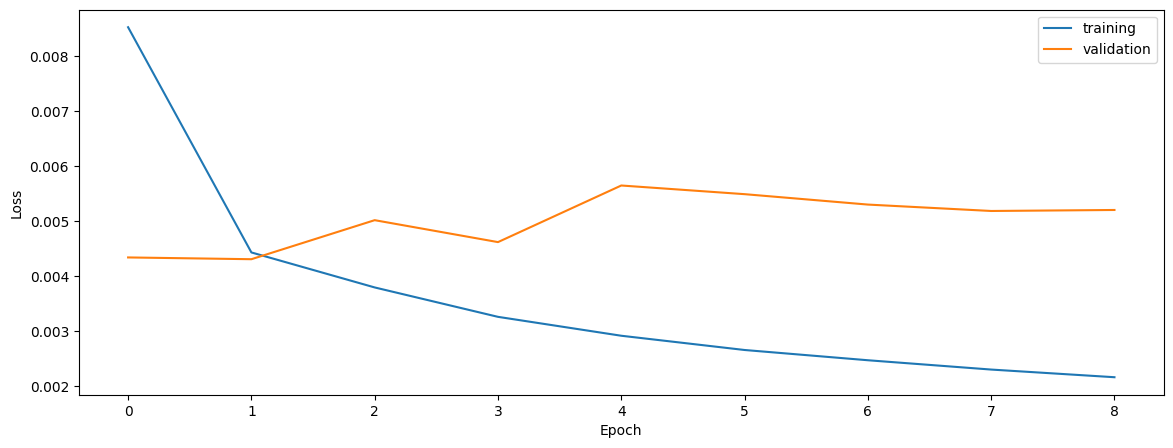

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9693636040574622
0.9584531072300153
0.9299201026572672


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.9142621337774327
0.9328509356861465
0.9220910175478371


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.9226204205324503
0.9376905057588115
0.933223279251887


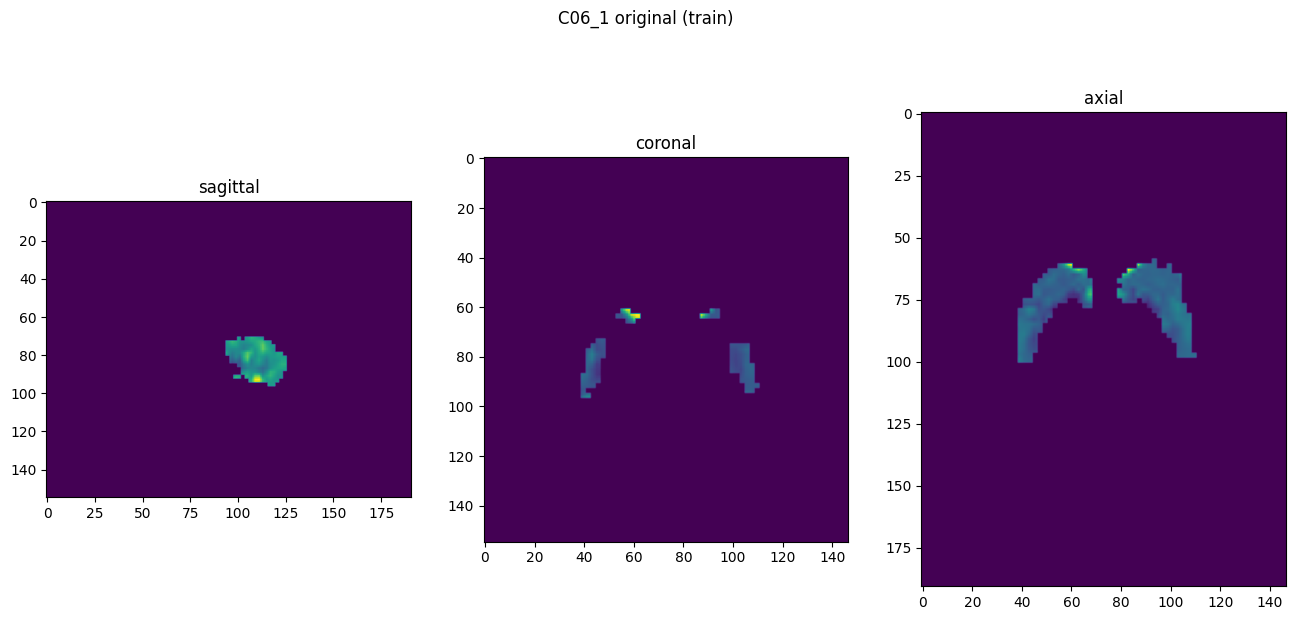

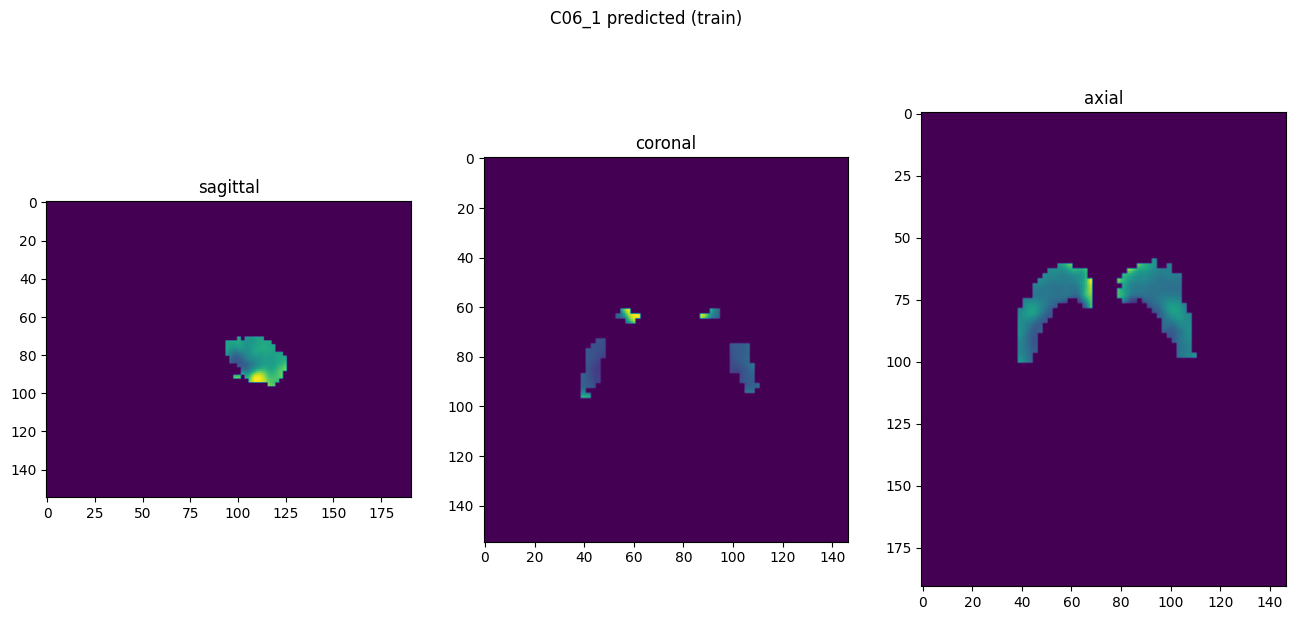

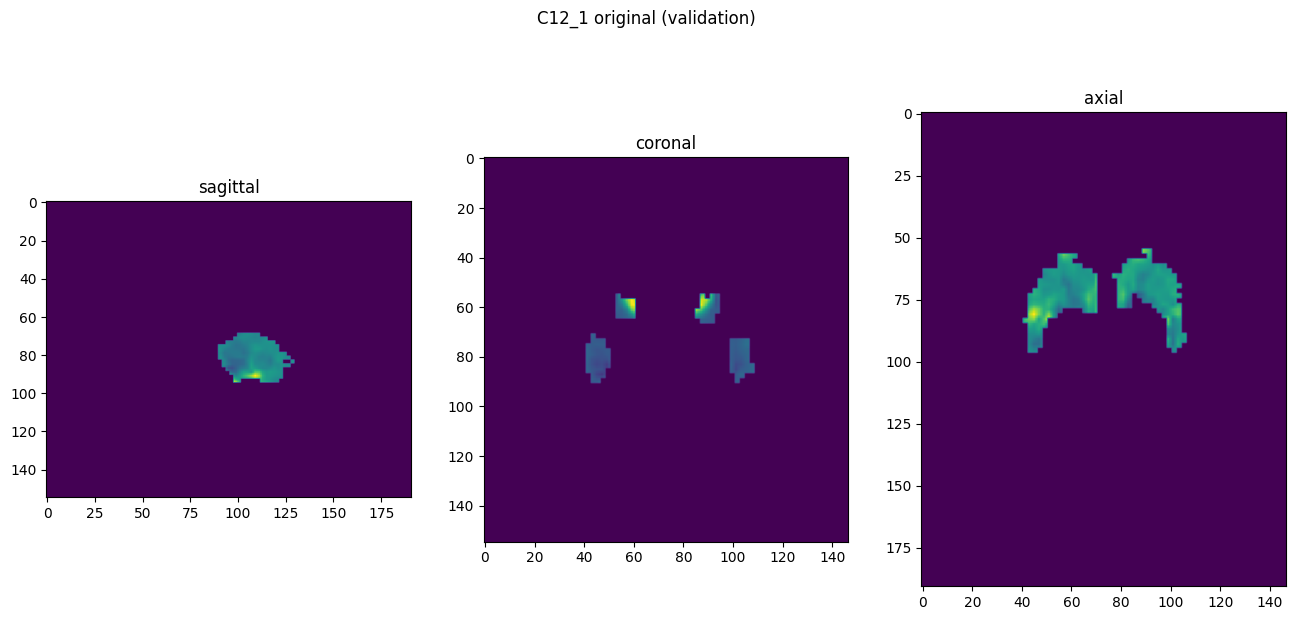

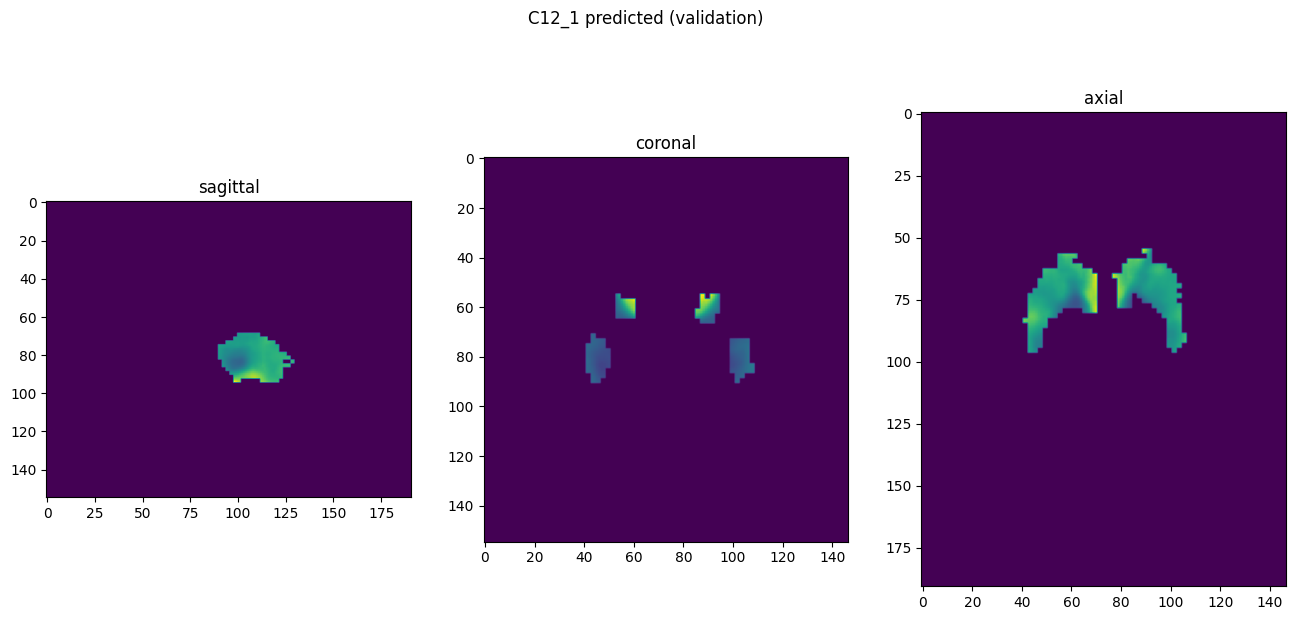

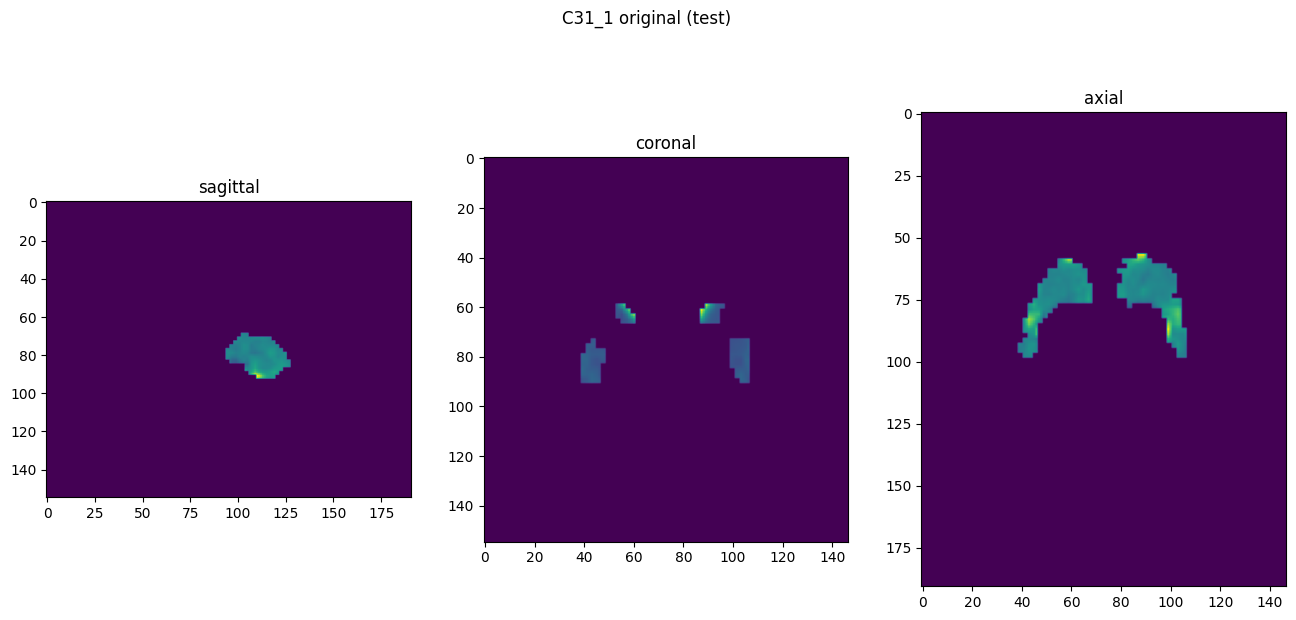

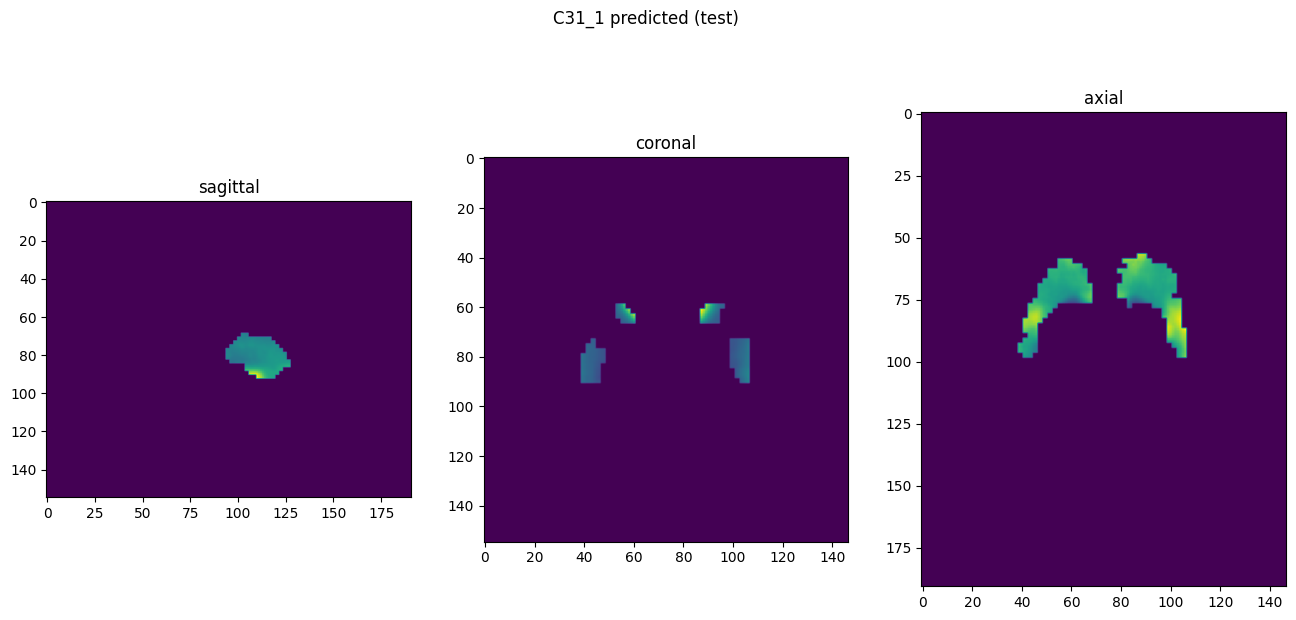

In [10]:
showResults(model, gen, threshold=None, background=False)